In [1]:
import pandas as pd
import numpy as np
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Goal

Increase Nuvei’s revenue by maximizing the potential of our users.

# Data

- *approved* transactions of users who made their first purchase between 01/04/2024 and 01/05/2024 with us --> we have a cohort of 1 month with 41,321 transaction (16,208 users)
- The data contains their first 4 months of purchases.

## Features

- payment_id: A unique identifier for each transaction.
- user_id: The unique identifier for each user in the dataset.
- merchant_id: The identifier for the merchant involved in the transaction.
- payment_timestamp: The date when the transaction was created.
- first_approved_payment_timestamp: The date the user joined the platform.
- total_amount_usd: The total value of the transaction in USD, representing the amount spent by the user.
- payment_instrument: The method of payment used in the transaction (e.g., Credit Card, PayPal, Apple Pay).
- currency: The currency used in the transaction (e.g., USD, AED, AUD).
- time_to_complete_payment: The time (in seconds) it took to complete the transaction.
- num_approved_payments_per_user: The number of approved transactions made by the user.
- total_approved_amount_usd_per_user: The total approved amount spent by the user in USD across all their transactions.
- country: The country of the user making the transaction.
- state: The state or region of the user, where applicable (for users from the US, for example).
- device_type: The type of device the user used for the transaction (e.g., mobile, PC).

In [2]:
df = pd.read_csv('/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/Home_Assignments/Nuvei_home_assignment/DS_Test_Dataset.csv')

In [3]:
df.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,total_approved_amount_usd_per_user,country,state,device_type
0,66675334,11008761,210,5/31/2024 23:56,5/31/2024 23:56,109.86,credit_card,CAD,7.045880,1,109.86,CA,NaN,pc
1,66675371,11008762,117,6/1/2024 0:00,6/1/2024 0:00,108.71,credit_card,USD,3.236956,1,108.71,US,DC,mobile
2,66675434,11008768,248,6/1/2024 0:07,6/1/2024 0:07,150.00,credit_card,USD,3.431595,1,150.00,US,MO,mobile
3,66675492,11008775,288,6/1/2024 0:12,6/1/2024 0:12,30.00,credit_card,USD,1.600267,1,30.00,US,TX,mobile
4,66675558,11008784,160,6/1/2024 0:18,6/1/2024 0:18,41.42,credit_card,EUR,2.335492,1,41.42,FR,NaN,mobile


In [4]:
df.shape

(41321, 14)

In [5]:
df.user_id.nunique()

16208

i see we have less user_id's than payment_id's

In [6]:
df.payment_id.nunique()

41321

the df is at payment_level as the number of payment_id's matches with the shape.

In [7]:
df.columns

Index(['payment_id', 'user_id', 'merchant_id', 'payment_timestamp',
       'first_approved_payment_timestamp', 'total_amount_usd',
       'payment_instrument', 'currency', 'time_to_complete_payment',
       'num_approved_payments_per_user', 'total_approved_amount_usd_per_user',
       'country', 'state', 'device_type'],
      dtype='object')

In [8]:
df.dtypes

payment_id                              int64
user_id                                 int64
merchant_id                             int64
payment_timestamp                      object
first_approved_payment_timestamp       object
total_amount_usd                      float64
payment_instrument                     object
currency                               object
time_to_complete_payment              float64
num_approved_payments_per_user          int64
total_approved_amount_usd_per_user    float64
country                                object
state                                  object
device_type                            object
dtype: object

In [9]:
(df.isna().sum()/df.isna().sum().sum()).sort_values(ascending=False)

state                                 0.999171
payment_instrument                    0.000414
device_type                           0.000414
payment_id                            0.000000
user_id                               0.000000
merchant_id                           0.000000
payment_timestamp                     0.000000
first_approved_payment_timestamp      0.000000
total_amount_usd                      0.000000
currency                              0.000000
time_to_complete_payment              0.000000
num_approved_payments_per_user        0.000000
total_approved_amount_usd_per_user    0.000000
country                               0.000000
dtype: float64

I see state has 99% missing values. Let's see first of all at what level should the model be (user or payment) and the importance of this feature in the model, and according to this decide if i should drop it or not.

# Workflow


## EDA

In [10]:
# how many payment_id's do we have per user?
df.groupby(['user_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False)

,user_id,payment_id
4681,11031911,275
10652,11062232,264
10346,11060763,183
16159,11092434,150
3105,11023684,139
...,...,...
6757,11042234,1
6758,11042238,1
6759,11042240,1
6761,11042252,1


In [11]:
df.groupby(['user_id'])['payment_id'].nunique().describe()

count    16208.000000
mean         2.549420
std          5.998501
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        275.000000
Name: payment_id, dtype: float64

In [12]:
# can we have multiple user_id for the same payment_id?
df.groupby(['payment_id'])['user_id'].nunique() #no

payment_id
66675334    1
66675371    1
66675434    1
66675492    1
66675558    1
           ..
69672855    1
69673681    1
69673750    1
69676107    1
69684451    1
Name: user_id, Length: 41321, dtype: int64

on average we have 2 payments per user. the distribution seems very skewed.

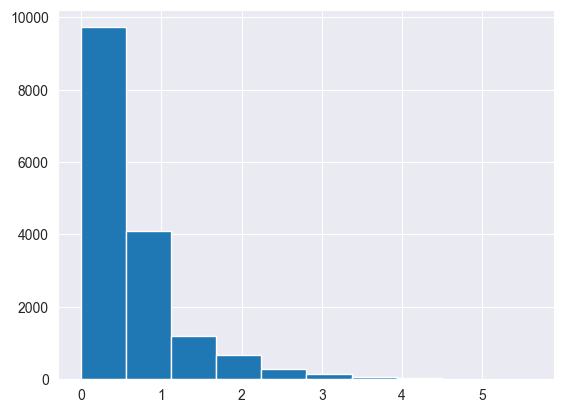

In [13]:
plt.hist(np.log(df.groupby(['user_id'])['payment_id'].nunique())) # using log to tackle skewness for better visualization
plt.show()

In [14]:
# how many merchant_id do you have per user_id and payment_id
merchants_per_user = df.groupby(['user_id'], as_index=False)['merchant_id'].nunique() # for each user we can have up to 6 merchants
merchants_per_user

,user_id,merchant_id
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,2
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [15]:
num_merchants_orders_by_user = df.groupby(['user_id'], as_index=False).agg(num_merchant=('merchant_id','nunique'), num_orders=('payment_id','nunique'), total_transaction_value=('total_amount_usd','sum')).sort_values(by=['num_merchant','num_orders'], ascending=[False, False])
num_merchants_orders_by_user
# num_merchants_orders_by_user[num_merchants_orders_by_user.num_merchant==1].user_id.nunique()


,user_id,num_merchant,num_orders,total_transaction_value
8459,11051121,6,47,50856.57
4273,11029560,4,15,31850.00
4681,11031911,3,275,164588.90
13728,11079099,3,94,9750.64
9185,11055227,3,63,37500.00
...,...,...,...,...
16203,11092755,1,1,100.00
16204,11092757,1,1,3000.00
16205,11092767,1,1,210.00
16206,11092771,1,1,213.35


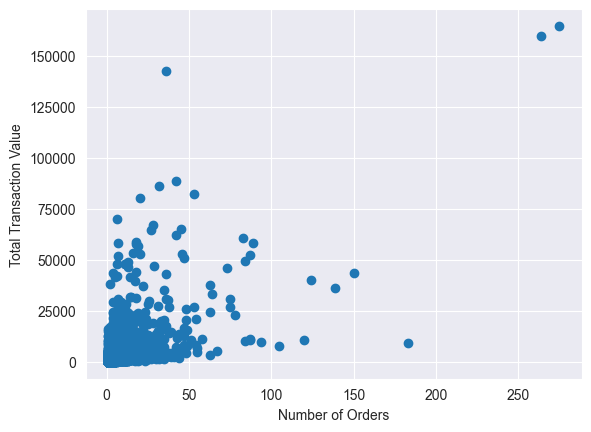

In [16]:
plt.scatter(num_merchants_orders_by_user.num_orders, num_merchants_orders_by_user.total_transaction_value)
plt.xlabel('Number of Orders')
plt.ylabel('Total Transaction Value')
plt.show()

In [17]:
num_merchants_orders_by_user.corr() # the higher the number of orders, the higher the spent

,user_id,num_merchant,num_orders,total_transaction_value
user_id,1.000000,0.025503,0.003450,0.002725
num_merchant,0.025503,1.000000,0.231905,0.176495
num_orders,0.003450,0.231905,1.000000,0.634776
total_transaction_value,0.002725,0.176495,0.634776,1.000000


In [18]:
# users that have more than 1 merchant id have more than 1 payment id as well
df[df.user_id.isin(merchants_per_user[merchants_per_user.merchant_id > 1].user_id)].groupby(['user_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False)

,user_id,payment_id
117,11031911,275
277,11060763,183
468,11092434,150
103,11029550,124
80,11025901,105
...,...,...
170,11043981,2
161,11042407,2
360,11075066,2
361,11075525,2


In [19]:
# do we have users that bought twice or more from the same merchant?
df.groupby(['user_id','merchant_id'], as_index=False)['payment_id'].nunique().sort_values(by=['payment_id'], ascending=False) #yes

,user_id,merchant_id,payment_id
10957,11062232,160,264
4806,11031911,602,264
10644,11060763,288,182
16666,11092434,602,146
3175,11023684,160,139
...,...,...,...
6935,11042262,602,1
6936,11042268,160,1
6937,11042273,265,1
6938,11042277,470,1


In [20]:
# for the same user, can we have multiple merchants for the same payment id?
df.groupby(['user_id', 'payment_id'], as_index=False)['merchant_id'].nunique()['merchant_id'].unique() # no, each payment_id is linked to to 1 merchant_id and 1 user

array([1])

so the hierarchy is: you have multiple users --> each user can buy from multiple merchants --> from each merchant a user can done multiple orders(payments).

In [21]:
# how many users do we have per merchant?
num_users_per_merchant = df.groupby(['merchant_id'], as_index=False)['user_id'].nunique()
num_users_per_merchant

,merchant_id,user_id
0,32,80
1,68,351
2,72,30
3,75,80
4,88,871
...,...,...
86,621,34
87,623,442
88,626,154
89,631,1


In [22]:
# Assuming `df` is your DataFrame
# Convert columns to datetime
df['payment_timestamp'] = pd.to_datetime(df['payment_timestamp'], format='%m/%d/%Y %H:%M')
df['first_approved_payment_timestamp'] = pd.to_datetime(df['first_approved_payment_timestamp'], format='%m/%d/%Y %H:%M')

# Analyze data period
first_date = df['payment_timestamp'].min()
last_date = df['payment_timestamp'].max()
print(f"Data period: {first_date} to {last_date}")

# Extract features
def extract_features(df, column):
    # df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month
    df[f'{column}_day'] = df[column].dt.day
    df[f'{column}_hour'] = df[column].dt.hour
    df[f'{column}_weekday'] = df[column].dt.day_name()
    df[f'{column}_is_weekend'] = df[column].dt.weekday.isin([5, 6]).astype(int)
    df[f'{column}_season'] = df[column].dt.month % 12 // 3
    df[f'{column}_time_range'] = pd.cut(
        df[column].dt.hour,
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        right=False
    )
    return df

df = extract_features(df, 'payment_timestamp')

# Compute time difference in days
df['time_diff_days'] = (df['payment_timestamp'] - df['first_approved_payment_timestamp']).dt.total_seconds() / (3600 * 24)


Data period: 2024-05-31 23:56:00 to 2024-10-28 11:47:00


In [23]:
# from this snapshot of user 11008761 i understand the user journey
df[(df.user_id == 11008761)]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,state,device_type,payment_timestamp_month,payment_timestamp_day,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days
0,66675334,11008761,210,2024-05-31 23:56:00,2024-05-31 23:56:00,109.86,credit_card,CAD,7.045880,1,...,NaN,pc,5,31,23,Friday,0,1,Evening,0.000000
9,66675675,11008761,210,2024-06-01 00:27:00,2024-05-31 23:56:00,109.86,credit_card,CAD,1.114166,2,...,NaN,pc,6,1,0,Saturday,1,2,Night,0.021528
49,66677571,11008761,210,2024-06-01 03:55:00,2024-05-31 23:56:00,87.89,credit_card,CAD,1.383882,3,...,NaN,pc,6,1,3,Saturday,1,2,Night,0.165972
56,66677971,11008761,210,2024-06-01 04:45:00,2024-05-31 23:56:00,54.93,credit_card,CAD,1.421333,4,...,NaN,pc,6,1,4,Saturday,1,2,Night,0.200694
232,66684319,11008761,210,2024-06-01 14:09:00,2024-05-31 23:56:00,73.25,credit_card,CAD,2.089430,5,...,NaN,pc,6,1,14,Saturday,1,2,Afternoon,0.592361
244,66684645,11008761,210,2024-06-01 14:29:00,2024-05-31 23:56:00,54.93,credit_card,CAD,1.139712,6,...,NaN,pc,6,1,14,Saturday,1,2,Afternoon,0.606250
296,66686087,11008761,210,2024-06-01 15:58:00,2024-05-31 23:56:00,73.25,credit_card,CAD,1.109149,7,...,NaN,pc,6,1,15,Saturday,1,2,Afternoon,0.668056
11593,66967019,11008761,210,2024-06-13 18:43:00,2024-05-31 23:56:00,94.57,credit_card,CAD,2.575146,8,...,NaN,mobile,6,13,18,Thursday,0,2,Evening,12.782639


example of user journey: a user did a first payment on 31.5.24. then they did 6 more payments on the following day and after 2 weeks on the 13.6.24 they did another payment. the sum of the total_amount_usd is equal to the 8th total_approved_amount_usd_per_user 658.54.

In [24]:
# do we have merchants that have a higher/lower total_amount_usd
avg_amount_by_merchant = df.groupby(['merchant_id'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])
avg_amount_by_merchant[avg_amount_by_merchant.total_num_users >= 375].sort_values(by=['avg_amount_usd'], ascending=False) #min sample size for statistically significant inference

,merchant_id,avg_amount_usd,total_num_users,total_num_orders
4,88,554.174564,871,2167
55,432,538.681649,441,867
80,602,519.610884,1305,3427
28,265,510.819229,490,1063
19,210,396.377249,487,1076
75,591,365.559382,592,1263
31,288,257.759991,4470,10424
9,160,251.440144,3045,7731
87,623,200.827342,442,952


In [25]:
# do we have payment instruments that have a higher/lower total_amount_usd
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,payment_instrument,avg_amount_usd,total_num_users,total_num_orders
2,google_pay,424.269472,161,436
1,credit_card,372.794623,16057,40859
3,NaN,192.638333,12,12
0,bank_transfer,50.653571,12,14


In [26]:
# do we have currencies that have a higher/lower total_amount_usd
df.groupby(['currency'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,currency,avg_amount_usd,total_num_users,total_num_orders
25,HKD,1016.712419,36,62
12,CHF,1010.561393,160,402
0,AED,903.703622,175,370
40,MXN,696.151596,44,94
43,NZD,691.488605,54,129
8,BMD,670.690000,2,3
31,JPY,628.695745,160,329
51,SGD,605.762646,228,514
17,CZK,571.129132,123,380
30,ISK,530.991875,6,16


In [27]:
# do we have countries that have a higher/lower total_amount_usd
df.groupby(['country'], as_index=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,country,avg_amount_usd,total_num_users,total_num_orders
50,GG,8641.250000,1,1
126,TV,3875.530000,2,4
91,MT,2320.958333,14,36
133,VI,1875.000000,2,6
9,AW,1006.250000,1,8
...,...,...,...,...
23,CG,47.275000,2,4
121,TG,41.230000,1,1
99,NP,39.750000,1,4
5,AO,36.580000,1,4


In [28]:
# do we have state that have a higher/lower total_amount_usd
df.groupby(['state'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,state,avg_amount_usd,total_num_users,total_num_orders
33,NM,2750.000000,1,2
49,WA,854.572344,28,64
28,NC,711.562778,113,378
41,RI,634.026667,5,9
43,SD,619.166667,6,12
42,SC,598.529559,76,204
8,DE,509.006250,21,56
38,PA,492.265565,111,372
27,MT,488.414286,11,21
35,OH,466.026430,122,465


In [29]:
# do we have device that have a higher/lower total_amount_usd
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_amount_usd=('total_amount_usd','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_amount_usd'], ascending=[False])

,device_type,avg_amount_usd,total_num_users,total_num_orders
3,pc,523.294786,2862,6145
0,mobile,347.262139,13447,34780
4,tablet,339.253913,70,115
1,no_data,318.706931,106,202
2,other,311.783433,29,67
5,NaN,192.638333,12,12


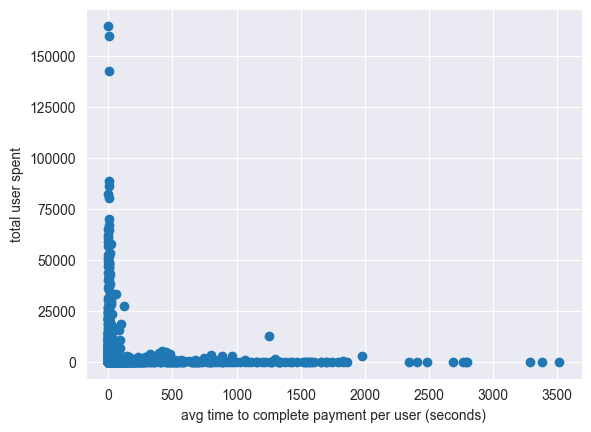

In [30]:
# does total spent decrease with time to complete payment?

amount_time_to_payment = df.groupby(['user_id'], as_index=False).agg(total_user_spent=('total_amount_usd','sum'), avg_time_to_complete_payment=('time_to_complete_payment','mean'))
plt.scatter(amount_time_to_payment.avg_time_to_complete_payment, amount_time_to_payment.total_user_spent)
plt.xlabel('avg time to complete payment per user (seconds)')
plt.ylabel('total user spent')
plt.show()

In [31]:
amount_time_to_payment.corr() # there is a slight negative correlation but not that strong -0.011307

,user_id,total_user_spent,avg_time_to_complete_payment
user_id,1.000000,0.002725,0.011664
total_user_spent,0.002725,1.000000,-0.011307
avg_time_to_complete_payment,0.011664,-0.011307,1.000000


In [32]:
# do we have merchants that have a higher/lower time_to_complete_payment
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,merchant_id,avg_time_to_complete_payment,total_num_users,total_num_orders
84,616,55.424567,30,43
73,582,48.777764,4,6
35,305,43.586637,2,4
17,201,38.006810,25,54
10,171,37.052898,6,7
...,...,...,...,...
42,346,2.376515,2,2
63,508,1.954826,1,1
79,599,1.822290,1,6
15,196,1.770718,1,3


In [33]:
# do we have payment instruments that have a higher/lower time_to_complete_payment
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,payment_instrument,avg_time_to_complete_payment,total_num_users,total_num_orders
2,google_pay,18.050337,161,436
1,credit_card,11.095096,16057,40859
3,NaN,8.756710,12,12
0,bank_transfer,7.519238,12,14


In [34]:
# do we have currencies that have a higher/lower time_to_complete_payment
df.groupby(['currency'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,currency,avg_time_to_complete_payment,total_num_users,total_num_orders
27,IDR,176.951260,6,7
2,AMD,78.165338,58,96
40,MXN,74.906082,44,94
25,HKD,67.760856,36,62
28,ILS,45.395084,62,176
33,KWD,40.738420,22,29
41,MYR,35.354414,48,94
49,RSD,34.568186,60,116
55,UAH,30.679493,97,131
53,TWD,29.773114,51,140


In [35]:
# do we have country that have a higher/lower time_to_complete_payment
df.groupby(['country'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,country,avg_time_to_complete_payment,total_num_users,total_num_orders
35,DM,251.276496,1,1
78,LR,188.804717,3,3
2,AG,115.939442,1,2
93,MX,104.469477,46,100
11,AZ,104.171918,15,27
...,...,...,...,...
99,NP,2.175954,1,4
10,AX,2.129569,1,2
89,MN,2.033728,1,3
15,BH,1.888225,5,52


In [36]:
# do we have state that have a higher/lower time_to_complete_payment
df.groupby(['state'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,state,avg_time_to_complete_payment,total_num_users,total_num_orders
48,VT,52.609110,6,10
8,DE,16.867928,21,56
49,WA,14.433155,28,64
53,NaN,14.040765,12635,28943
30,NE,13.343137,24,56
7,DC,11.563738,25,62
18,LA,10.044098,1,1
46,UT,9.146686,68,304
9,FL,8.367473,31,62
6,CT,7.572223,124,312


In [37]:
# do we have device that have a higher/lower time_to_complete_payment
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_time_to_complete_payment=('time_to_complete_payment','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_to_complete_payment'], ascending=[False])

,device_type,avg_time_to_complete_payment,total_num_users,total_num_orders
4,tablet,12.608673,70,115
0,mobile,11.311789,13447,34780
3,pc,10.577383,2862,6145
5,NaN,8.756710,12,12
1,no_data,5.812254,106,202
2,other,3.934709,29,67


tablet is the device type with highest average time to complete payment.

In [38]:
# do we have merchants that have a higher/lower time_diff_days
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,merchant_id,avg_time_diff_days,total_num_users,total_num_orders
56,455,39.734132,6,20
25,243,33.034130,247,1274
52,417,30.319476,109,282
85,618,30.200468,203,792
39,320,28.945166,65,252
...,...,...,...,...
61,495,0.000000,1,1
78,597,0.000000,1,1
63,508,0.000000,1,1
65,519,0.000000,1,1


In [39]:
# do we have payment instruments that have a higher/lower time_diff_days
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,payment_instrument,avg_time_diff_days,total_num_users,total_num_orders
1,credit_card,15.663070,16057,40859
2,google_pay,13.971120,161,436
3,NaN,1.312326,12,12
0,bank_transfer,0.342510,12,14


In [40]:
# do we have currencies that have a higher/lower time_diff_days
df.groupby(['currency'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,currency,avg_time_diff_days,total_num_users,total_num_orders
7,BHD,91.372873,3,48
14,CNY,35.818194,1,5
56,USD,22.801255,4609,14007
35,MAD,21.978540,10,51
53,TWD,18.012966,51,140
31,JPY,15.657166,160,329
21,GBP,15.492919,2038,5289
12,CHF,14.671305,160,402
28,ILS,14.090195,62,176
40,MXN,13.487566,44,94


In [41]:
# do we have country that have a higher/lower time_diff_days
df.groupby(['country'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,country,avg_time_diff_days,total_num_users,total_num_orders
15,BH,88.103592,5,52
47,GD,57.697933,1,43
25,CI,41.379178,33,354
82,MA,40.400621,16,94
5,AO,39.141667,1,4
...,...,...,...,...
87,MG,0.000000,1,1
121,TG,0.000000,1,1
37,DZ,0.000000,2,2
35,DM,0.000000,1,1


In [42]:
# do we have state that have a higher/lower time_diff_days
df.groupby(['state'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,state,avg_time_diff_days,total_num_users,total_num_orders
37,OR,40.591672,45,277
23,MI,36.000552,108,557
46,UT,33.089988,68,304
50,WI,31.095341,40,168
4,CA,29.978082,461,1790
45,TX,28.425812,370,1449
0,AL,27.904202,65,357
47,VA,27.325242,100,547
12,IA,26.280690,24,62
28,NC,25.894626,113,378


In [43]:
# do we have device that have a higher/lower time_diff_days
df.groupby(['device_type'], as_index=False, dropna=False).agg(avg_time_diff_days=('time_diff_days','mean'), total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['avg_time_diff_days'], ascending=[False])

,device_type,avg_time_diff_days,total_num_users,total_num_orders
2,other,27.003141,29,67
0,mobile,15.807555,13447,34780
3,pc,14.931293,2862,6145
1,no_data,9.471119,106,202
4,tablet,7.057814,70,115
5,NaN,1.312326,12,12


In [44]:
# do we have merchants that have a higher/lower total_num_orders
df.groupby(['merchant_id'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,merchant_id,total_num_users,total_num_orders
31,288,4470,10424
9,160,3045,7731
80,602,1305,3427
4,88,871,2167
25,243,247,1274
...,...,...,...
34,303,1,1
65,519,1,1
40,327,1,1
68,557,1,1


In [45]:
# do we have payment instruments that have a higher/lower total_num_orders
df.groupby(['payment_instrument'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,payment_instrument,total_num_users,total_num_orders
1,credit_card,16057,40859
2,google_pay,161,436
0,bank_transfer,12,14
3,NaN,12,12


In [46]:
# do we have currencies that have a higher/lower total_num_orders
df.groupby(['currency'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,currency,total_num_users,total_num_orders
56,USD,4609,14007
20,EUR,5824,12616
21,GBP,2038,5289
11,CAD,637,1384
4,AUD,372,919
46,PLN,296,641
42,NOK,274,593
51,SGD,228,514
48,RON,256,514
12,CHF,160,402


In [47]:
# do we have country that have a higher/lower total_num_orders
df.groupby(['country'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,country,total_num_users,total_num_orders
129,US,2980,10939
46,GB,1757,5011
33,DE,1202,2665
45,FR,1161,2120
67,IT,889,1820
...,...,...,...
57,GU,1,1
35,DM,1,1
87,MG,1,1
54,GQ,1,1


In [48]:
# do we have state that have a higher/lower total_num_orders
df.groupby(['state'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,state,total_num_users,total_num_orders
53,NaN,12635,28943
4,CA,461,1790
45,TX,370,1449
20,MD,232,690
23,MI,108,557
47,VA,100,547
14,IL,140,545
10,GA,183,486
35,OH,122,465
28,NC,113,378


In [49]:
# do we have device that have a higher/lower total_num_orders
df.groupby(['device_type'], as_index=False, dropna=False).agg(total_num_users=('user_id','nunique'), total_num_orders=('payment_id','nunique')).sort_values(by=['total_num_orders'], ascending=[False])

,device_type,total_num_users,total_num_orders
0,mobile,13447,34780
3,pc,2862,6145
1,no_data,106,202
4,tablet,70,115
2,other,29,67
5,NaN,12,12


- Bucket users by loyalty level - how loyal they are for each merchant, how many transaction, or avg transaction x months. Action: Provide a loyalty tier upgrade, VIP support, or targeted marketing to cement loyalty.

In [50]:
df.groupby(['user_id','merchant_id','payment_timestamp_month'], as_index=False)['payment_id'].nunique()

,user_id,merchant_id,payment_timestamp_month,payment_id
0,11008761,210,5,1
1,11008761,210,6,7
2,11008762,117,6,1
3,11008768,248,6,1
4,11008770,160,7,1
...,...,...,...,...
19943,11092755,160,6,1
19944,11092757,602,6,1
19945,11092767,210,6,1
19946,11092771,459,6,1


In [51]:
# Step 1: Frequency of interaction
loyalty_frequency = df.groupby(['user_id', 'merchant_id'], as_index=False)['payment_timestamp_month'].nunique()
loyalty_frequency.rename(columns={'payment_timestamp_month': 'num_active_months'}, inplace=True)

# Step 2: Recency
df['last_payment_month'] = df.groupby(['user_id', 'merchant_id'])['payment_timestamp_month'].transform('max')
most_recent_month = df['payment_timestamp_month'].max()
df['recency'] = most_recent_month - df['last_payment_month']

# Step 3: Average transactions per month
avg_tx_per_month = df.groupby(['user_id', 'merchant_id'], as_index=False)['payment_id'].nunique()
avg_tx_per_month = avg_tx_per_month.groupby(['user_id', 'merchant_id'], as_index=False)['payment_id'].mean()
avg_tx_per_month.rename(columns={'payment_id': 'avg_tx_per_month'}, inplace=True)

# Step 4: Join metrics to compute loyalty score
loyalty_df = loyalty_frequency.merge(avg_tx_per_month, on=['user_id', 'merchant_id'])
loyalty_df = loyalty_df.merge(df[['user_id', 'merchant_id', 'recency']].drop_duplicates(), on=['user_id', 'merchant_id'])

# Normalize and compute loyalty score
loyalty_df['loyalty_score'] = (
    0.4 * (loyalty_df['num_active_months'] / loyalty_df['num_active_months'].max()) +
    0.3 * (1 - (loyalty_df['recency'] / loyalty_df['recency'].max())) +
    0.3 * (loyalty_df['avg_tx_per_month'] / loyalty_df['avg_tx_per_month'].max())
)


In [52]:
loyalty_df

,user_id,merchant_id,num_active_months,avg_tx_per_month,recency,loyalty_score
0,11008761,210,2,8.0,4,0.169091
1,11008762,117,1,1.0,4,0.081136
2,11008768,248,1,1.0,4,0.081136
3,11008770,160,1,1.0,3,0.156136
4,11008770,618,1,1.0,4,0.081136
...,...,...,...,...,...,...
16714,11092755,160,1,1.0,4,0.081136
16715,11092757,602,1,1.0,4,0.081136
16716,11092767,210,1,1.0,4,0.081136
16717,11092771,459,1,1.0,4,0.081136


users that bought from merchants 602, 160 are the most loyal one in terms of:
- number of months they've been active
- their last payment has been very recently
- they spend a higher average transaction value.

In [53]:
df.groupby(['payment_instrument', 'device_type','merchant_id','currency','country','state'], as_index=False).agg(num_users=('user_id','nunique'),num_orders=('payment_id','nunique'),total_amount=('total_amount_usd','sum')).sort_values(by=['total_amount'], ascending=[False])

,payment_instrument,device_type,merchant_id,currency,country,state,num_users,num_orders,total_amount
724,credit_card,mobile,602,USD,US,CA,14,266,149404.44
850,credit_card,mobile,626,USD,US,NC,8,60,130952.00
219,credit_card,mobile,160,USD,US,TX,97,431,109193.90
368,credit_card,mobile,243,USD,US,TX,13,165,99129.39
489,credit_card,mobile,288,USD,US,VA,12,129,95736.00
...,...,...,...,...,...,...,...,...,...
1091,credit_card,pc,288,USD,US,GA,1,1,30.00
693,credit_card,mobile,595,USD,US,NC,1,1,30.00
169,credit_card,mobile,160,INR,IN,UT,1,1,30.00
176,credit_card,mobile,160,USD,ES,CT,1,1,30.00


the most lucrative segment of users are users who pay with credit card from mobile, for merchant 602 in USD, in california. while the most recurring ones are users that pay with credit card, through mobile, to merchant_id 160 in USD in california.

In [54]:
# how many times does a user pay per month? we want to look at the monthly payment rate

num_payments_per_user_per_month = df.groupby(['user_id'], as_index=False).agg(num_active_months=('payment_timestamp_month','nunique'),num_orders=('payment_id','nunique'))
num_payments_per_user_per_month['monthly_payment_rate'] = num_payments_per_user_per_month['num_orders']/num_payments_per_user_per_month['num_active_months']
num_payments_per_user_per_month.sort_values(by=['monthly_payment_rate'], ascending=[False])

,user_id,num_active_months,num_orders,monthly_payment_rate
4681,11031911,5,275,55.0
10652,11062232,5,264,52.8
3583,11025901,2,105,52.5
4099,11028635,2,75,37.5
10346,11060763,5,183,36.6
...,...,...,...,...
6639,11041759,1,1,1.0
6640,11041764,1,1,1.0
6641,11041771,1,1,1.0
6642,11041774,1,1,1.0


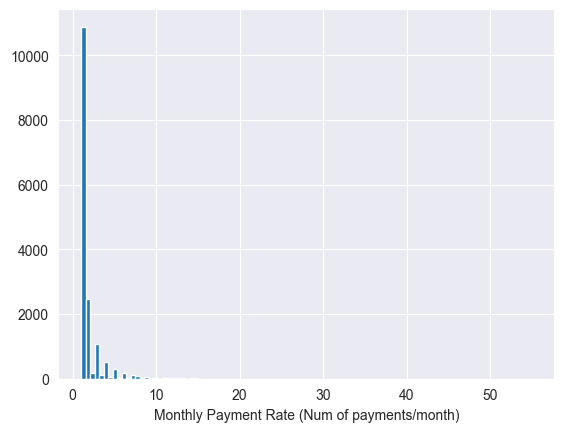

In [55]:
# let's see the distribution of the monthly payment rate: very skewed
plt.hist(num_payments_per_user_per_month['monthly_payment_rate'], bins=100)
plt.xlabel('Monthly Payment Rate (Num of payments/month)')
plt.show()

from the histogram we can see that the right tail of high-rate spenders starts around an average of 10 payments/month. So that's the threshold that I'm gonna use to define high rate spenders.

In [56]:
# let's see if these high-rate spenders have some particular characteristics

high_rate_spenders = df[df.user_id.isin(num_payments_per_user_per_month[num_payments_per_user_per_month.monthly_payment_rate > 10].user_id)]

In [57]:
# what's the average total amount usd per user
high_rate_spenders.groupby(['user_id'])['total_amount_usd'].mean().describe()

count     149.000000
mean      525.254845
std       619.440479
min        36.454545
25%       120.818182
50%       364.285714
75%       655.952360
max      4363.636364
Name: total_amount_usd, dtype: float64

on average these users spend 525 usd.

In [58]:
# let's see what's the most common payment instrument: credit card
high_rate_spenders.groupby(['payment_instrument'])['user_id'].nunique()

payment_instrument
credit_card    147
google_pay       3
Name: user_id, dtype: int64

In [59]:
# let's see what's the most common currency
high_rate_spenders.groupby(['currency'], as_index=False)['user_id'].nunique().sort_values(by=['user_id'], ascending=[False]).head(3)

,currency,user_id
21,USD,73
7,EUR,41
8,GBP,27


the top 3 most common currencies of high-rate spenders are USD, EUR and GBP.

In [60]:
# what's the average time to complete payment (in seconds)?
high_rate_spenders.groupby(['user_id'])['time_to_complete_payment'].mean().describe()

count    149.000000
mean       4.636623
std       11.672658
min        0.667492
25%        1.524497
50%        2.148510
75%        3.168844
max       95.253272
Name: time_to_complete_payment, dtype: float64

the average time to complete a payment for high rate spenders is 4 seconds almost 5.

In [61]:
# what's the most frequent country of high-rate spenders
high_rate_spenders.groupby(['country'], as_index=False)['user_id'].nunique().sort_values(by=['user_id'], ascending=[False]).head(3)

,country,user_id
35,US,62
14,GB,20
26,NL,6


US and GB are the top 2 countries from which high-rate spenders come from

In [62]:
# what's the most frequent mobile device of high-rate spenders: mobile
high_rate_spenders.groupby(['device_type'], as_index=False)['user_id'].nunique()

,device_type,user_id
0,mobile,142
1,pc,24


In [63]:
# these are the countries for which state is available
df[~df.state.isna()].country.drop_duplicates()

1        US
63       AE
80       CL
95       ES
124      NL
131      BE
147      FR
539      NI
632      JP
644      PL
725      ID
726      AU
836      GB
1216     RO
1563     PT
1622     CO
2340     DE
2365     HU
2707     BR
2902     GT
3322     MD
3503     MU
3535     LA
4807     IL
5091     IN
5201     LT
6029     UY
6088     LR
6253     BW
6871     UA
8960     OM
9113     IT
10006    GY
10273    CH
12304    KZ
15137    KW
18458    AT
20074    MX
21320    CZ
21375    AZ
22147    GR
33617    LV
34018    SE
40675    EE
Name: country, dtype: object

In [64]:
# we say high-rate spenders. now let's see high-value spenders

tot_value_per_user_per_month = df.groupby(['user_id'], as_index=False).agg(num_active_months=('payment_timestamp_month','nunique'),num_orders=('payment_id','nunique'), tot_spent=('total_amount_usd','sum'))
tot_value_per_user_per_month['monthly_payment_value'] = tot_value_per_user_per_month['tot_spent']/tot_value_per_user_per_month['num_active_months']
tot_value_per_user_per_month.sort_values(by=['monthly_payment_value'], ascending=[False])

,user_id,num_active_months,num_orders,tot_spent,monthly_payment_value
2753,11021938,1,11,48000.00,48000.00
5563,11036484,1,29,46840.00,46840.00
8240,11049809,1,13,46333.99,46333.99
10128,11059604,1,17,39542.49,39542.49
12716,11074149,1,2,38426.78,38426.78
...,...,...,...,...,...
9249,11055472,1,1,29.91,29.91
8443,11051061,1,1,29.88,29.88
4334,11029935,1,1,29.72,29.72
5875,11038177,1,1,29.58,29.58


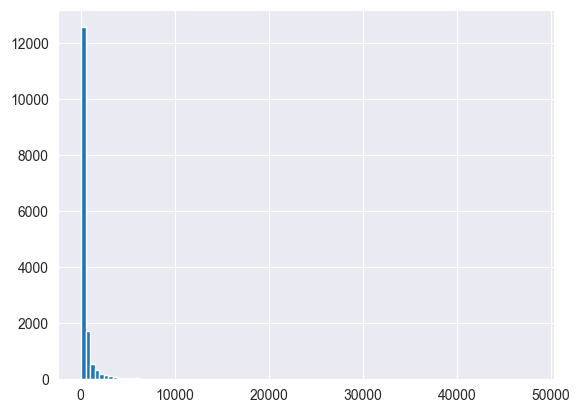

In [65]:
plt.hist(tot_value_per_user_per_month.monthly_payment_value, bins=100)
plt.show()

In [66]:
tot_value_per_user_per_month['monthly_payment_value'].describe() # the average spent for high-value spenders is 633

count    16208.000000
mean       633.545448
std       1977.299251
min         29.200000
25%         64.280000
50%        150.250000
75%        450.000000
max      48000.000000
Name: monthly_payment_value, dtype: float64

In [67]:
# let's look at high spenders as those users that spend more than an average of 10k USD/month (right tail)

# what's the average number of orders?
tot_value_per_user_per_month[tot_value_per_user_per_month['monthly_payment_value'] > 10000].num_orders.mean()

19.225352112676056

users that spend more than 10 times a month spend on averag 525usd, while users that on average spend 633usd a month - they do it in 19 payments on average.


In [68]:
high_value_users = df[df.user_id.isin(tot_value_per_user_per_month[tot_value_per_user_per_month['monthly_payment_value'] > 10000].user_id)]

In [69]:
high_value_users.payment_instrument.value_counts()

payment_instrument
credit_card    2729
google_pay        1
Name: count, dtype: int64

In [70]:
high_value_users.currency.value_counts()

currency
USD    1297
EUR     695
GBP     310
CAD      82
CHF      70
AED      60
PLN      36
AUD      33
CZK      28
SGD      26
NZD      17
MXN      17
BRL      15
ILS       9
CLP       9
NOK       9
JPY       6
GEL       6
DKK       3
HKD       2
Name: count, dtype: int64

In [71]:
high_value_users.time_to_complete_payment.mean()

4.332079050549451

In [72]:
high_value_users.country.value_counts()

country
US    1232
GB     328
CI     264
CH     149
CA      98
NL      71
DE      69
IT      58
AE      58
AU      42
SK      42
FR      37
PL      32
SG      26
ES      23
MT      20
CZ      20
NZ      17
MX      17
PT      17
BE      16
AT      15
BR      15
CL      10
IL       9
NO       9
DK       8
GE       6
SI       5
VI       4
LT       4
CY       4
JP       2
HK       2
RO       1
Name: count, dtype: int64

In [73]:
high_value_users.device_type.value_counts()

device_type
mobile    2163
pc         561
tablet       6
Name: count, dtype: int64

In [74]:
df.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_month,payment_timestamp_day,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency
0,66675334,11008761,210,2024-05-31 23:56:00,2024-05-31 23:56:00,109.86,credit_card,CAD,7.045880,1,...,5,31,23,Friday,0,1,Evening,0.0,6,4
1,66675371,11008762,117,2024-06-01 00:00:00,2024-06-01 00:00:00,108.71,credit_card,USD,3.236956,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
2,66675434,11008768,248,2024-06-01 00:07:00,2024-06-01 00:07:00,150.00,credit_card,USD,3.431595,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
3,66675492,11008775,288,2024-06-01 00:12:00,2024-06-01 00:12:00,30.00,credit_card,USD,1.600267,1,...,6,1,0,Saturday,1,2,Night,0.0,6,4
4,66675558,11008784,160,2024-06-01 00:18:00,2024-06-01 00:18:00,41.42,credit_card,EUR,2.335492,1,...,6,1,0,Saturday,1,2,Night,0.0,7,3


Text(0, 0.5, 'Total Amount USD')

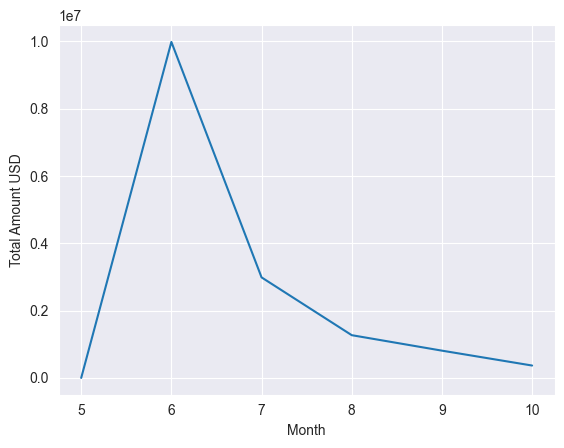

In [75]:
# overall spending trend

plt.plot(df.groupby(['payment_timestamp_month'])['total_amount_usd'].sum())
plt.xlabel('Month')
plt.ylabel('Total Amount USD')

overall the highest spending month among all users is june.

In [76]:
# let's identify the trend per user
pivoted_df = df.pivot_table(
    index='user_id',                    # Rows (unique user IDs)
    columns='payment_timestamp_month',  # Columns (months)
    values='total_amount_usd',          # Values to fill
    aggfunc='sum',                      # Aggregate function (sum in case of duplicates)
    fill_value=0                        # Fill missing values with 0
)

# Reset column names for better readability
pivoted_df.columns = [f'month_{int(col)}' for col in pivoted_df.columns]

# Reset the index if needed
pivoted_df.reset_index(inplace=True)

pivoted_df


,user_id,month_5,month_6,month_7,month_8,month_9,month_10
0,11008761,109.86,548.68,0.0,0.0,0.0,0.0
1,11008762,0.00,108.71,0.0,0.0,0.0,0.0
2,11008768,0.00,150.00,0.0,0.0,0.0,0.0
3,11008770,0.00,275.00,65.0,0.0,0.0,0.0
4,11008774,0.00,3000.00,1000.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
16203,11092755,0.00,100.00,0.0,0.0,0.0,0.0
16204,11092757,0.00,3000.00,0.0,0.0,0.0,0.0
16205,11092767,0.00,210.00,0.0,0.0,0.0,0.0
16206,11092771,0.00,213.35,0.0,0.0,0.0,0.0


In [77]:
# Calculate month-to-month differences for each user
monthly_diff = pivoted_df.set_index('user_id').diff(axis=1)

In [78]:
monthly_diff

,month_5,month_6,month_7,month_8,month_9,month_10
user_id,,,,,,
11008761,NaN,438.82,-548.68,0.0,0.0,0.0
11008762,NaN,108.71,-108.71,0.0,0.0,0.0
11008768,NaN,150.00,-150.00,0.0,0.0,0.0
11008770,NaN,275.00,-210.00,-65.0,0.0,0.0
11008774,NaN,3000.00,-2000.00,-1000.0,0.0,0.0
...,...,...,...,...,...,...
11092755,NaN,100.00,-100.00,0.0,0.0,0.0
11092757,NaN,3000.00,-3000.00,0.0,0.0,0.0
11092767,NaN,210.00,-210.00,0.0,0.0,0.0


In [79]:
# Check if the differences are positive (spending increases)
increasing_users = monthly_diff.apply(lambda x: all(x > 0), axis=1)

In [80]:
increasing_users.drop_duplicates() # there is no user whose spending trend is constantly increasing

user_id
11008761    False
dtype: bool

I look at payment_instrument, country, currency, device_type. the questions that I am trying to answer:
- for which countries switching to local currency would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
- for which countries switching to a certain payment method would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
- for which countries switching to a certain device type would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

In [81]:
# Function to get the official currency for a country
def get_official_currency(country_code):
    try:
        # Retrieve country information using the alpha_2 code
        country = pycountry.countries.get(alpha_2=country_code)
        if country:
            # Retrieve the currency information for the country
            currency = pycountry.currencies.get(numeric=country.numeric)
            return currency.alpha_3 if currency else None
        return None
    except:
        return None

# Example: Add the official currency column for your DataFrame
df['official_currency'] = df['country'].apply(get_official_currency)

# Manual mapping of countries to their official currencies
missing_countries_to_currency = {
    'FR': 'EUR', 'AT': 'EUR', 'IT': 'EUR', 'DE': 'EUR', 'SI': 'EUR', 'NL': 'EUR',
    'TW': 'TWD', 'PT': 'EUR', 'ES': 'EUR', 'RO': 'RON', 'PL': 'PLN', 'CI': 'XOF',
    'UA': 'UAH', 'LT': 'EUR', 'GR': 'EUR', 'BE': 'EUR', 'RS': 'RSD', 'FI': 'EUR',
    'CY': 'EUR', 'BR': 'BRL', 'IE': 'EUR', 'SK': 'EUR', 'ME': 'EUR', 'EE': 'EUR',
    'LV': 'EUR', 'PR': 'USD', 'AG': 'XCD', 'GE': 'GEL', 'GF': 'EUR', 'GH': 'GHS',
    'AZ': 'AZN', 'ET': 'ETB', 'MT': 'EUR', 'NC': 'XPF', 'RE': 'EUR', 'EC': 'USD',
    'MQ': 'EUR', 'JE': 'GBP', 'LU': 'EUR', 'GP': 'EUR', 'CG': 'XAF', 'AD': 'EUR',
    'DM': 'XCD', 'PF': 'XPF', 'VI': 'USD', 'GD': 'XCD', 'TG': 'XOF', 'BJ': 'XOF',
    'GL': 'DKK', 'LI': 'CHF', 'CW': 'ANG', 'MG': 'MGA', 'FO': 'DKK', 'LC': 'XCD',
    'GQ': 'XAF', 'AO': 'AOA', 'GG': 'GBP', 'BA': 'BAM', 'CK': 'NZD', 'TC': 'USD',
    'MC': 'EUR', 'AX': 'EUR', 'VG': 'USD', 'MF': 'EUR', 'TJ': 'TJS', 'GU': 'USD',
    'BQ': 'USD', 'TV': 'AUD'
}

# Fill missing official currencies
df['official_currency'] = df['official_currency'].fillna(df['country'].map(missing_countries_to_currency))


In [82]:
df['is_paying_in_local_currency'] = np.where(df['currency']==df['official_currency'],1,0)

In [83]:
# for which countries switching to local currency would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?
local_vs_nonlocal = df.groupby(['country', 'is_paying_in_local_currency']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for local and non-local currency
local_vs_nonlocal['spending_per_user'] = local_vs_nonlocal['tot_spent'] / local_vs_nonlocal['tot_num_users']
local_vs_nonlocal['orders_per_user'] = local_vs_nonlocal['tot_num_orders'] / local_vs_nonlocal['tot_num_users']

# Separate local and non-local currencies
local = local_vs_nonlocal[local_vs_nonlocal['is_paying_in_local_currency'] == 1]
non_local = local_vs_nonlocal[local_vs_nonlocal['is_paying_in_local_currency'] == 0]

# Merge local and non-local metrics for comparison
comparison = local.merge(non_local, on='country', suffixes=('_local', '_non_local'))

# Identify countries with high potential for switching to local currency
opportunity_countries = comparison[
    (comparison['spending_per_user_non_local'] < comparison['spending_per_user_local']) &
    (comparison['orders_per_user_non_local'] < comparison['orders_per_user_local']) &
    (comparison['avg_time_to_complete_payment_non_local'] > comparison['avg_time_to_complete_payment_local'])
]

# Calculate percentage changes for per-user metrics
opportunity_countries['spending_increase_pct'] = (
    (opportunity_countries['spending_per_user_local'] - opportunity_countries['spending_per_user_non_local']) /
    opportunity_countries['spending_per_user_non_local']
) * 100

opportunity_countries['orders_increase_pct'] = (
    (opportunity_countries['orders_per_user_local'] - opportunity_countries['orders_per_user_non_local']) /
    opportunity_countries['orders_per_user_non_local']
) * 100

opportunity_countries['time_to_payment_decrease_pct'] = (
    (opportunity_countries['avg_time_to_complete_payment_non_local'] - opportunity_countries['avg_time_to_complete_payment_local']) /
    opportunity_countries['avg_time_to_complete_payment_non_local']
) * 100

# Display the results
opportunity_countries[['country', 'spending_increase_pct', 'orders_increase_pct', 'time_to_payment_decrease_pct']].sort_values(by=['spending_increase_pct'], ascending=[False]).head(3)


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/452105547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opportunity_countries['spending_increase_pct'] = (
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/452105547.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opportunity_countries['orders_increase_pct'] = (
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/452105547.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,country,spending_increase_pct,orders_increase_pct,time_to_payment_decrease_pct
55,MT,8172.391162,190.909091,69.753701
8,BH,1730.429079,1100.000000,49.893491
67,RE,351.300000,50.000000,29.274080


We found 16 countries that if we switch to local currency fully we would have an increase in spending per user, in orders per user and a decrease in time to payment. I would give priority to countries like Bahrain, Mexico and Reunion where the percentage increase in spend per user from switching to local currency is the highest.


In [84]:
#for which countries switching to a certain payment method would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

# Step 1: Identify users with more than 1 payment instrument
users_multiple_payment_instruments = df.groupby(['country', 'user_id'])['payment_instrument'].nunique().reset_index()
users_multiple_payment_instruments = users_multiple_payment_instruments[users_multiple_payment_instruments['payment_instrument'] > 1]

# Step 2: Filter the original DataFrame to include only these users
df_filtered = df[df['user_id'].isin(users_multiple_payment_instruments['user_id'])]

# Step 3: Recalculate metrics for these filtered users
local_vs_nonlocal_payment_filtered = df_filtered.groupby(['country', 'payment_instrument']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for each payment method
local_vs_nonlocal_payment_filtered['spending_per_user'] = (
    local_vs_nonlocal_payment_filtered['tot_spent'] / local_vs_nonlocal_payment_filtered['tot_num_users']
)
local_vs_nonlocal_payment_filtered['orders_per_user'] = (
    local_vs_nonlocal_payment_filtered['tot_num_orders'] / local_vs_nonlocal_payment_filtered['tot_num_users']
)

local_vs_nonlocal_payment_filtered[['country', 'payment_instrument','avg_time_to_complete_payment', 'spending_per_user','orders_per_user']]


,country,payment_instrument,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AT,credit_card,1.943852,546.330000,2.500000
1,AT,google_pay,5.732765,410.785000,1.000000
2,DE,credit_card,4.097874,1955.363333,5.000000
3,DE,google_pay,15.215767,2044.903333,3.666667
4,ES,credit_card,6.358709,1013.053333,3.000000
5,ES,google_pay,7.772085,728.853333,2.333333
6,FR,credit_card,4.965903,437.351111,1.777778
7,FR,google_pay,13.549358,1335.081111,3.333333
8,GB,credit_card,4.021262,2831.510000,12.000000
9,GB,google_pay,8.248953,94.065000,1.000000


for each country, we want to switch to the payment instrument that has a lower time to complete payment, a higher spending per user and a higher number of orders per user:
- AT: Austria: google pay --> credit card
- DE: Germany: google pay --> credit card
- ES: Spain: google pay --> credit card
- FR: France: credit card --> google pay (even if time to payment is 2 times higher, spending per user is 3 times higher and number of orders per user is 2 times higher in google pay)
- GB: United Kingdom (Great Britain) google pay --> credit card
- HU: Hungary: google pay --> credit card
- IT: Italy: credit card --> google pay
- NL: Netherlands: google pay --> credit card
- PL: Poland: credit card --> google pay

In [85]:
# Step 1: Separate data for each payment instrument
credit_card_data = local_vs_nonlocal_payment_filtered[local_vs_nonlocal_payment_filtered['payment_instrument'] == 'credit_card']
google_pay_data = local_vs_nonlocal_payment_filtered[local_vs_nonlocal_payment_filtered['payment_instrument'] == 'google_pay']

# Step 2: Merge the two datasets by country
merged_data = credit_card_data.merge(
    google_pay_data,
    on='country',
    suffixes=('_credit_card', '_google_pay')
)

# Step 3: Define countries for specific switches
switch_to_credit_card = ['AT', 'DE', 'ES', 'GB', 'HU', 'NL']  # Countries switching Google Pay --> Credit Card
switch_to_google_pay = ['FR', 'IT', 'PL']  # Countries switching Credit Card --> Google Pay

# Step 4: Calculate percentage changes for each country
merged_data['spending_change_pct'] = merged_data.apply(
    lambda row: ((row['spending_per_user_credit_card'] - row['spending_per_user_google_pay']) /
                 row['spending_per_user_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['spending_per_user_google_pay'] - row['spending_per_user_credit_card']) /
          row['spending_per_user_credit_card'] * 100),
    axis=1
)

merged_data['orders_change_pct'] = merged_data.apply(
    lambda row: ((row['orders_per_user_credit_card'] - row['orders_per_user_google_pay']) /
                 row['orders_per_user_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['orders_per_user_google_pay'] - row['orders_per_user_credit_card']) /
          row['orders_per_user_credit_card'] * 100),
    axis=1
)

merged_data['time_change_pct'] = merged_data.apply(
    lambda row: ((row['avg_time_to_complete_payment_google_pay'] - row['avg_time_to_complete_payment_credit_card']) /
                 row['avg_time_to_complete_payment_google_pay'] * 100)
    if row['country'] in switch_to_credit_card
    else ((row['avg_time_to_complete_payment_credit_card'] - row['avg_time_to_complete_payment_google_pay']) /
          row['avg_time_to_complete_payment_credit_card'] * 100),
    axis=1
)

# Step 5: Add a direction column
merged_data['direction'] = merged_data['country'].apply(
    lambda x: 'google_pay --> credit_card' if x in switch_to_credit_card else 'credit_card --> google_pay'
)

# Step 6: Select and display relevant columns
result = merged_data[['country', 'direction', 'spending_change_pct', 'orders_change_pct', 'time_change_pct']]
result


,country,direction,spending_change_pct,orders_change_pct,time_change_pct
0,AT,google_pay --> credit_card,32.996580,150.000000,66.092247
1,DE,google_pay --> credit_card,-4.378691,36.363636,73.068238
2,ES,google_pay --> credit_card,38.992756,28.571429,18.185295
3,FR,credit_card --> google_pay,205.265284,87.500000,-172.847844
4,GB,google_pay --> credit_card,2910.163185,1100.000000,51.251240
5,HU,google_pay --> credit_card,-14.561313,33.333333,-3.816850
6,IT,credit_card --> google_pay,788.369929,100.000000,69.596639
7,NL,google_pay --> credit_card,527.345999,218.181818,96.605214
8,PL,credit_card --> google_pay,933.728856,150.000000,61.016030


In [86]:
#for which countries switching to a certain device type would generate an increase in spend per user, an increase in transactions per user and a decrease in time to payment?

# Step 1: Identify users with more than 1 payment instrument
users_multiple_device = df.groupby(['country', 'user_id'])['device_type'].nunique().reset_index()
users_multiple_device = users_multiple_device[users_multiple_device['device_type'] > 1]


# Step 2: Filter the original DataFrame to include only these users
df_filtered = df[df['user_id'].isin(users_multiple_device['user_id'])]

# Step 3: Recalculate metrics for these filtered users
local_vs_nonlocal_device = df_filtered.groupby(['country', 'device_type']).agg(
    tot_num_users=('user_id', 'nunique'),
    tot_num_orders=('payment_id', 'nunique'),
    tot_spent=('total_amount_usd', 'sum'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean')
).reset_index()

# Add per-user metrics for each payment method
local_vs_nonlocal_device['spending_per_user'] = (
    local_vs_nonlocal_device['tot_spent'] / local_vs_nonlocal_device['tot_num_users']
)
local_vs_nonlocal_device['orders_per_user'] = (
    local_vs_nonlocal_device['tot_num_orders'] / local_vs_nonlocal_device['tot_num_users']
)

local_vs_nonlocal_device[['country', 'device_type','avg_time_to_complete_payment', 'spending_per_user','orders_per_user']]


,country,device_type,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AE,mobile,2.939277,6806.365000,2.500000
1,AE,pc,17.798664,3115.373333,3.333333
2,AE,tablet,2.562771,1185.040000,4.000000
3,AT,mobile,69.973106,790.675000,3.333333
4,AT,no_data,5.958840,295.650000,1.000000
...,...,...,...,...,...
122,US,other,3.246808,2580.000000,8.000000
123,US,pc,2.413883,2742.672857,8.285714
124,US,tablet,6.544071,122.500000,3.000000
125,UY,mobile,2.775460,137.745000,1.000000


In [87]:
# Define the function to select the best device type for each country
def select_best_device(group):
    # Sort the group by spending, orders, and time
    sorted_group = group.sort_values(
        by=['spending_per_user', 'orders_per_user', 'avg_time_to_complete_payment'],
        ascending=[False, False, True]
    )
    return sorted_group.iloc[0]  # Return the top row after sorting

# Apply the selection logic to each group
best_device_per_country = (
    local_vs_nonlocal_device.groupby('country', group_keys=False)
    .apply(select_best_device)
    .reset_index(drop=True)
)

# Display the relevant columns
best_device_per_country = best_device_per_country[['country', 'device_type', 'avg_time_to_complete_payment', 'spending_per_user', 'orders_per_user']]
best_device_per_country


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/343285023.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(select_best_device)


,country,device_type,avg_time_to_complete_payment,spending_per_user,orders_per_user
0,AE,mobile,2.939277,6806.365000,2.500000
1,AT,mobile,69.973106,790.675000,3.333333
2,AU,mobile,22.482972,381.903333,2.333333
3,BE,mobile,3.533151,303.450000,2.000000
4,BS,pc,5.884061,65.750000,1.000000
5,CA,pc,4.285154,4252.001538,4.076923
6,CH,pc,4.444943,6643.620833,7.666667
7,CO,pc,3.017417,446.135000,3.000000
8,CR,pc,18.644589,51.030000,1.000000
9,CY,mobile,4.145336,16177.280000,3.000000


we found the top device for each country.

In [88]:
best_device_per_country.groupby(['device_type'])['country'].nunique()

device_type
mobile    27
pc        24
Name: country, dtype: int64

for almost 50% of the countries the best device type is mobile, and 50% pc.

In [89]:
# do we have different countries per user?
num_countries_per_user = df.groupby(['user_id'], as_index=False)['country'].nunique()
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)][['user_id','country']].drop_duplicates()
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].user_id.nunique()

42

we have 42 users that made transactions from different countries

In [90]:
df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].groupby(['user_id','country'], as_index=False)['payment_id'].nunique()

,user_id,country,payment_id
0,11010845,PR,2
1,11010845,US,1
2,11014508,AU,1
3,11014508,GB,1
4,11015604,NO,1
...,...,...,...
79,11090498,CH,3
80,11091300,CA,8
81,11091300,US,3
82,11091873,CH,1


In [91]:
payments_spent_multiple_countries = df[df.user_id.isin(num_countries_per_user[num_countries_per_user.country > 1].user_id)].groupby(['user_id']).agg(num_payments=('payment_id', 'nunique'), total_spent=('total_amount_usd', 'sum'))
payments_spent_multiple_countries.describe()

,num_payments,total_spent
count,42.000000,42.000000
mean,7.928571,5642.527143
std,13.594104,11932.281415
min,2.000000,61.340000
25%,3.000000,311.602500
50%,4.000000,1207.045000
75%,8.750000,3431.955000
max,89.000000,58379.760000


the average spent of users that do transactions from more than 1 country is 5600 usd.

In [92]:
# do we have different countries per merchant?

df.groupby(['merchant_id'])['country'].nunique() #yes

merchant_id
32     27
68     37
72     16
75     23
88     53
       ..
621    14
623    42
626     5
631     1
635     9
Name: country, Length: 91, dtype: int64

In [93]:
# do we have different payment_instruments per user? yes - up to 1

df.groupby(['user_id'], as_index=False)['payment_instrument'].nunique()

,user_id,payment_instrument
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [94]:
# 0 payment instruments --> payment instrument is unavailable

df[df.user_id.isin([11044603,
11013467,
11048803,
11089752,
11046392,
11062442,
11034252,
11013255,
11055675]
)]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency
999,66709990,11013255,160,2024-06-02 20:35:00,2024-06-02 20:35:00,150.00,NaN,USD,5.201039,1,...,20,Sunday,1,2,Evening,0.0,6,4,USD,1
1042,66711676,11013467,579,2024-06-02 22:41:00,2024-06-02 22:41:00,60.58,NaN,EUR,5.981655,1,...,22,Sunday,1,2,Evening,0.0,6,4,EUR,1
7577,66880677,11034252,579,2024-06-10 08:01:00,2024-06-10 08:01:00,128.70,NaN,DKK,7.504261,1,...,8,Monday,0,2,Morning,0.0,6,4,DKK,1
10961,66954966,11044603,579,2024-06-13 09:38:00,2024-06-13 09:38:00,51.54,NaN,EUR,7.448137,1,...,9,Thursday,0,2,Morning,0.0,6,4,UAH,0
11653,66968282,11046392,579,2024-06-13 19:42:00,2024-06-13 19:42:00,270.00,NaN,USD,31.058294,1,...,19,Thursday,0,2,Evening,0.0,6,4,UZS,0
12556,66988065,11048803,160,2024-06-14 15:38:00,2024-06-14 15:38:00,480.00,NaN,USD,2.259987,1,...,15,Friday,0,2,Afternoon,0.0,6,4,USD,1
14813,67044963,11055675,288,2024-06-17 12:06:00,2024-06-17 12:06:00,55.69,NaN,EUR,17.581732,1,...,12,Monday,0,2,Afternoon,0.0,6,4,EUR,1
17574,67097354,11062442,288,2024-06-19 17:58:00,2024-06-19 17:58:00,76.30,NaN,GBP,3.075067,1,...,17,Wednesday,0,2,Afternoon,0.0,6,4,GBP,1
28350,67309513,11089752,417,2024-06-29 15:42:00,2024-06-29 15:42:00,117.92,NaN,EUR,2.869514,1,...,15,Saturday,1,2,Afternoon,0.0,6,4,EUR,1


In [95]:
# do we have different currency per user? yes - up to 3
df.groupby(['user_id'], as_index=False)['currency'].nunique()

,user_id,currency
0,11008761,1
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [96]:
# do we have different device_type per user? yes - up to 3

df.groupby(['user_id'], as_index=False)['device_type'].nunique()

,user_id,device_type
0,11008761,2
1,11008762,1
2,11008768,1
3,11008770,1
4,11008774,1
...,...,...
16203,11092755,1
16204,11092757,1
16205,11092767,1
16206,11092771,1


In [97]:
# no device type --> same users with no payment instrument

df[df.user_id.isin([11034252,
11013467,
11062442,
11046392,
11044603,
11048803,
11089752,
11055675,
11013255
])]

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_hour,payment_timestamp_weekday,payment_timestamp_is_weekend,payment_timestamp_season,payment_timestamp_time_range,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency
999,66709990,11013255,160,2024-06-02 20:35:00,2024-06-02 20:35:00,150.00,NaN,USD,5.201039,1,...,20,Sunday,1,2,Evening,0.0,6,4,USD,1
1042,66711676,11013467,579,2024-06-02 22:41:00,2024-06-02 22:41:00,60.58,NaN,EUR,5.981655,1,...,22,Sunday,1,2,Evening,0.0,6,4,EUR,1
7577,66880677,11034252,579,2024-06-10 08:01:00,2024-06-10 08:01:00,128.70,NaN,DKK,7.504261,1,...,8,Monday,0,2,Morning,0.0,6,4,DKK,1
10961,66954966,11044603,579,2024-06-13 09:38:00,2024-06-13 09:38:00,51.54,NaN,EUR,7.448137,1,...,9,Thursday,0,2,Morning,0.0,6,4,UAH,0
11653,66968282,11046392,579,2024-06-13 19:42:00,2024-06-13 19:42:00,270.00,NaN,USD,31.058294,1,...,19,Thursday,0,2,Evening,0.0,6,4,UZS,0
12556,66988065,11048803,160,2024-06-14 15:38:00,2024-06-14 15:38:00,480.00,NaN,USD,2.259987,1,...,15,Friday,0,2,Afternoon,0.0,6,4,USD,1
14813,67044963,11055675,288,2024-06-17 12:06:00,2024-06-17 12:06:00,55.69,NaN,EUR,17.581732,1,...,12,Monday,0,2,Afternoon,0.0,6,4,EUR,1
17574,67097354,11062442,288,2024-06-19 17:58:00,2024-06-19 17:58:00,76.30,NaN,GBP,3.075067,1,...,17,Wednesday,0,2,Afternoon,0.0,6,4,GBP,1
28350,67309513,11089752,417,2024-06-29 15:42:00,2024-06-29 15:42:00,117.92,NaN,EUR,2.869514,1,...,15,Saturday,1,2,Afternoon,0.0,6,4,EUR,1


In [98]:
# number of states per country
df.groupby(['country'], dropna=False)['state'].nunique()

country
AD     0
AE     1
AG     0
AL     0
AM     0
      ..
US    48
UY     2
UZ     0
VG     0
VI     0
Name: state, Length: 134, dtype: int64

## My strategy to predict user's LTV

First of all, since we have a dataframe of all approved transactions, I understand that we want to focus on how to increase growth from existing users. This influences also the granularity of the model - instead of being a real time, transaction-level model, i will go for a user-level granularity with aggregated historical data, where the model will work as a weekly or monthly batch process.

To increase Nuvei's revenue, i estimate the predicted LTV per user. Action items based on this:
- share insights on predicted LTV with merchants to help them target those users with campaigns (increase both number of payments and total transaction value)
- if a user has a low predicted LTV, check what's the bottleneck: payment method, device or currency --> and recommend the action that can increase the number of transactions

Steps to predict user LTV:
1. split the users into cohorts based on the month of the first approved payment timestamp: this is the date the user joined the platform
2. do cohort analysis: here we want to look for the period where the majority of user payments are concentrated. this is going to be our observational window. we want to use the first months with higher retention rate to build the features, and then we compute the LTV based on the following months.
2. Define the observation window: from the moment the user joined the platform, define a fixed period to aggregate features based on months with high retention rate from cohort analysis
3. Define the label window: from the moment the user joined the platform, define a subsequent fixed period to compute the LTV label after the observation window.
4. merge the aggregated data at user level: features and LTV label
5. split train-dev-test by user to avoid leakage

## Cohort Analysis

In [99]:
# cohort analysis
df['first_approved_payment_month'] = df['first_approved_payment_timestamp'].dt.month

In [100]:
cohort_analysis = df.groupby(['first_approved_payment_month','payment_timestamp_month']).agg(num_payments=('payment_id','nunique'), num_users=('user_id','nunique'))
cohort_analysis

num_payments  num_users
first_approved_payment_month payment_timestamp_month                         
5                            5                                   1          1
                             6                                   7          1
6                            6                               29529      16203
                             7                                5988       1836
                             8                                2937        802
                             9                                1959        490
                             10                                900        262

In [101]:
#since we have only 1 user that did its first approved payment on may, we define our cohort of users as those users that did the first approved payment inn june --> we drop it
df = df[df.first_approved_payment_month == 6]

In [102]:
cohort_analysis = df.groupby(['first_approved_payment_month','payment_timestamp_month']).agg(num_payments=('payment_id','nunique'), num_users=('user_id','nunique'))
cohort_analysis

num_payments  num_users
first_approved_payment_month payment_timestamp_month                         
6                            6                               29529      16203
                             7                                5988       1836
                             8                                2937        802
                             9                                1959        490
                             10                                900        262

In [103]:
# Create a pivot table to analyze payments over time
cohort_pivot = cohort_analysis.pivot_table(
    index='first_approved_payment_month',  # Rows: Cohorts based on first payment month
    columns='payment_timestamp_month',    # Columns: Subsequent payment months
    values='num_payments',                # Values: Number of payments
    aggfunc='sum'                         # Aggregate function
).fillna(0)  # Fill missing values with 0

# Calculate the percentage of payments per cohort over time
cohort_percentage = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100

# Display the cohort analysis table
print("Cohort Payments (Raw Counts):")
print(cohort_pivot)

print("\nCohort Payments (Percentage Retention):")
print(cohort_percentage)


Cohort Payments (Raw Counts):
payment_timestamp_month          6     7     8     9    10
first_approved_payment_month                              
6                             29529  5988  2937  1959  900

Cohort Payments (Percentage Retention):
payment_timestamp_month          6         7         8         9         10
first_approved_payment_month                                               
6                             100.0  20.27837  9.946155  6.634156  3.047851


The retention drops significantly after month 7. We will use june and july as observation window, and august to october as LTV label.
Capturing months 6 and 7 as observation windows ensures:
- Sufficient data for feature engineering.
- High signal-to-noise ratio from user engagement.

## Split into observation and label window

In [104]:

observation_months = [6, 7]  # Observation: June–July
label_months = [8, 9, 10]  # Label: August–October

# Add flags for observation and label windows
df['is_observation'] = df['payment_timestamp_month'].isin(observation_months)
df['is_label'] = df['payment_timestamp_month'].isin(label_months)

df_features = df[df['is_observation']]
df_labels = df[df['is_label']]

In [105]:
conversion_rates = {
    ('USD', 'EUR'): 0.85, ('USD', 'CAD'): 1.25, ('EUR', 'HUF'): 350.0, ('USD', 'PLN'): 4.0,
    ('EUR', 'USD'): 1.18, ('RON', 'EUR'): 0.20, ('USD', 'GBP'): 0.72, ('EUR', 'ARS'): 119.0,
    ('GBP', 'EUR'): 1.15, ('EUR', 'XOF'): 656.0, ('USD', 'KZT'): 450.0, ('USD', 'RSD'): 105.0,
    ('USD', 'CZK'): 23.0, ('AUD', 'PLN'): 3.0, ('EUR', 'MKD'): 61.5, ('USD', 'BRL'): 5.2,
    ('GBP', 'PLN'): 5.3, ('USD', 'CHF'): 0.92, ('USD', 'UAH'): 38.0, ('USD', 'BSD'): 1.0,
    ('EUR', 'PLN'): 4.5, ('USD', 'SVC'): 8.75, ('EUR', 'UAH'): 40.0, ('EUR', 'MAD'): 11.0,
    ('USD', 'XCD'): 2.7, ('XOF', 'EUR'): 0.00152, ('USD', 'NIO'): 36.5, ('USD', 'AUD'): 1.4,
    ('USD', 'MUR'): 45.0, ('AUD', 'CHF'): 0.62, ('USD', 'KWD'): 0.31, ('USD', 'SEK'): 10.5,
    ('USD', 'PEN'): 3.8, ('CHF', 'QAR'): 4.1, ('RON', 'UAH'): 8.2, ('EUR', 'RON'): 5.0,
    ('AUD', 'EUR'): 0.64, ('USD', 'AED'): 3.67, ('HUF', 'CZK'): 0.06, ('USD', 'HUF'): 350.0,
    ('USD', 'ETB'): 55.0, ('USD', 'DKK'): 6.8, ('EUR', 'CZK'): 24.5, ('EUR', 'GBP'): 0.87,
    ('USD', 'CRC'): 540.0, ('USD', 'ARS'): 850.0, ('USD', 'HKD'): 7.8, ('EUR', 'SEK'): 11.0,
    ('GBP', 'RON'): 5.8, ('USD', 'SGD'): 1.35, ('GEL', 'PLN'): 1.6, ('GBP', 'AED'): 4.5,
    ('NOK', 'EUR'): 0.09, ('PLN', 'UAH'): 9.0, ('EUR', 'CLP'): 970.0, ('EUR', 'DKK'): 7.45,
    ('GBP', 'CZK'): 28.0, ('EUR', 'XPF'): 120.0, ('USD', 'RON'): 4.6, ('KZT', 'RSD'): 0.23,
    ('USD', 'TOP'): 2.3, ('EUR', 'CHF'): 0.98, ('GEL', 'MYR'): 1.6, ('HUF', 'EUR'): 0.0028,
    ('USD', 'GEL'): 2.7, ('AUD', 'NZD'): 1.1, ('USD', 'IDR'): 15750.0, ('USD', 'ILS'): 3.7,
    ('GBP', 'USD'): 1.24, ('SEK', 'NOK'): 1.02, ('USD', 'RWF'): 1250.0, ('GBP', 'HUF'): 401.0,
    ('GBP', 'NOK'): 13.5, ('SGD', 'AUD'): 1.05, ('USD', 'KHR'): 4100.0, ('USD', 'NOK'): 10.0,
    ('PLN', 'NOK'): 2.25, ('USD', 'NZD'): 1.6, ('SEK', 'RSD'): 10.5, ('HUF', 'RON'): 0.0135,
    ('EUR', 'RSD'): 117.5, ('MYR', 'QAR'): 0.8, ('GBP', 'CHF'): 1.10, ('USD', 'AMD'): 390.0,
    ('USD', 'ISK'): 139.0, ('EUR', 'NOK'): 10.5, ('EUR', 'ALL'): 102.0, ('DKK', 'NOK'): 1.42,
    ('USD', 'MXN'): 18.0, ('BRL', 'AED'): 0.74, ('USD', 'HNL'): 24.5, ('HKD', 'GBP'): 0.10,
    ('EUR', 'ILS'): 3.9, ('USD', 'INR'): 82.0, ('USD', 'XAF'): 656.0, ('USD', 'LAK'): 21000.0,
    ('CAD', 'CLP'): 700.0, ('CAD', 'UAH'): 28.0, ('PEN', 'COP'): 1000.0, ('AUD', 'KHR'): 3000.0,
    ('USD', 'MYR'): 4.6, ('USD', 'UYU'): 38.0, ('GBP', 'DKK'): 8.5, ('AUD', 'TWD'): 20.0,
    ('SGD', 'NZD'): 1.13, ('EUR', 'SGD'): 1.48, ('KZT', 'THB'): 0.078, ('EUR', 'ISK'): 153.0,
    ('USD', 'COP'): 3850.0, ('CHF', 'EUR'): 1.02, ('GBP', 'INR'): 105.0, ('EUR', 'PEN'): 4.2,
    ('KZT', 'UZS'): 27.0, ('USD', 'MAD'): 10.1, ('USD', 'TND'): 3.1, ('HUF', 'GBP'): 0.0025,
    ('PLN', 'EUR'): 0.22, ('USD', 'UZS'): 12500.0, ('USD', 'MDL'): 18.5, ('EUR', 'COP'): 4500.0,
    ('PLN', 'GBP'): 0.19, ('USD', 'BMD'): 1.0, ('NZD', 'GBP'): 0.49, ('UAH', 'CZK'): 0.61,
}

In [106]:

# Function to compute potential savings
def compute_savings_fixed_rate(row):
    try:
        # If the transaction is already in the local currency, no savings
        if row['currency'] == row['official_currency']:
            return 0.0

        # Get the conversion rate for the currency pair
        conversion_rate = conversion_rates.get((row['currency'], row['official_currency']))
        if not conversion_rate:
            return None  # Conversion rate not found

        # Calculate the amount in the local currency
        amount_in_local_currency = row['total_amount_usd'] / conversion_rate

        # Calculate potential savings
        potential_savings = row['total_amount_usd'] - amount_in_local_currency
        return max(potential_savings, 0)  # Ensure savings are non-negative
    except Exception as e:
        print(f"Error computing savings for row {row['user_id']}: {e}")
        return None

# Apply the function to compute potential savings for each transaction
df_features['potential_savings'] = df_features.apply(compute_savings_fixed_rate, axis=1)


/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/4156547050.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['potential_savings'] = df_features.apply(compute_savings_fixed_rate, axis=1)


In [107]:
df_features.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,payment_timestamp_time_range,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency,first_approved_payment_month,is_observation,is_label,potential_savings
1,66675371,11008762,117,2024-06-01 00:00:00,2024-06-01 00:00:00,108.71,credit_card,USD,3.236956,1,...,Night,0.0,6,4,USD,1,6,True,False,0.0
2,66675434,11008768,248,2024-06-01 00:07:00,2024-06-01 00:07:00,150.00,credit_card,USD,3.431595,1,...,Night,0.0,6,4,USD,1,6,True,False,0.0
3,66675492,11008775,288,2024-06-01 00:12:00,2024-06-01 00:12:00,30.00,credit_card,USD,1.600267,1,...,Night,0.0,6,4,USD,1,6,True,False,0.0
4,66675558,11008784,160,2024-06-01 00:18:00,2024-06-01 00:18:00,41.42,credit_card,EUR,2.335492,1,...,Night,0.0,7,3,EUR,1,6,True,False,0.0
5,66675583,11008774,88,2024-06-01 00:20:00,2024-06-01 00:20:00,1000.00,credit_card,USD,1.416019,1,...,Night,0.0,7,3,USD,1,6,True,False,0.0


In [108]:
df_features.columns

Index(['payment_id', 'user_id', 'merchant_id', 'payment_timestamp',
       'first_approved_payment_timestamp', 'total_amount_usd',
       'payment_instrument', 'currency', 'time_to_complete_payment',
       'num_approved_payments_per_user', 'total_approved_amount_usd_per_user',
       'country', 'state', 'device_type', 'payment_timestamp_month',
       'payment_timestamp_day', 'payment_timestamp_hour',
       'payment_timestamp_weekday', 'payment_timestamp_is_weekend',
       'payment_timestamp_season', 'payment_timestamp_time_range',
       'time_diff_days', 'last_payment_month', 'recency', 'official_currency',
       'is_paying_in_local_currency', 'first_approved_payment_month',
       'is_observation', 'is_label', 'potential_savings'],
      dtype='object')

## Aggregate LTV of label window

In [109]:
ltv_labels = df_labels.groupby(['user_id'], as_index=False).agg(total_spent_label=('total_amount_usd', 'sum'))

## Feature aggregation of observation window

In [110]:
aggregated_features = df_features.groupby(['user_id'], as_index=False).agg(
    num_merchants=('merchant_id', 'nunique'),
    total_spent=('total_amount_usd', 'sum'),
    num_payment_instruments=('payment_instrument', 'nunique'),
    num_currencies=('currency', 'nunique'),
    avg_time_to_complete_payment=('time_to_complete_payment', 'mean'),
    total_unique_payments=('payment_id', 'nunique'),
    num_distinct_countries=('country', 'nunique'),
    num_distinct_states=('state', 'nunique'),
    num_distinct_device_types=('device_type', 'nunique'),
    avg_time_diff_days=('time_diff_days','mean')
)

In [111]:
# Recency: Days since the last payment
recency_feature = df_features.groupby('user_id').agg(
    last_payment_date=('payment_timestamp', 'max')
).reset_index()
recency_feature['recency'] = (df_features['payment_timestamp'].max() - recency_feature['last_payment_date']).dt.days

# Clumpiness: Measure if payments are clustered on the same day
def calculate_clumpiness(group):
    unique_days = group['payment_timestamp'].dt.date.nunique()
    total_payments = group['payment_id'].nunique()
    return total_payments / unique_days if unique_days > 0 else 0

clumpiness_feature = df_features.groupby('user_id').apply(calculate_clumpiness).reset_index()
clumpiness_feature.columns = ['user_id', 'clumpiness']

# Is Local Currency Used: Proportion of payments made in local currency
local_currency_feature = df_features.groupby('user_id').agg(
    local_currency_payments=('is_paying_in_local_currency', 'sum'),
    total_payments=('payment_id', 'count')
).reset_index()
local_currency_feature['local_currency_ratio'] = local_currency_feature['local_currency_payments'] / local_currency_feature['total_payments']

# Payment Growth Rate: Trend of payments during the observation window
def calculate_payment_growth(group):
    observation_window = group[group['is_observation']]
    if len(observation_window) < 2:
        return 0  # No growth if there are fewer than 2 months of payments
    payment_counts = observation_window.groupby('payment_timestamp_month')['payment_id'].nunique()
    months = payment_counts.index
    growth_rate = (payment_counts.values[-1] - payment_counts.values[0]) / len(months) if len(months) > 1 else 0
    return growth_rate

payment_growth_feature = df_features.groupby('user_id').apply(calculate_payment_growth).reset_index()
payment_growth_feature.columns = ['user_id', 'payment_growth_rate']

# Merge all features into the aggregated dataset
aggregated_features = aggregated_features.merge(recency_feature[['user_id', 'recency']], on='user_id', how='left')
aggregated_features = aggregated_features.merge(clumpiness_feature, on='user_id', how='left')
aggregated_features = aggregated_features.merge(local_currency_feature[['user_id', 'local_currency_ratio']], on='user_id', how='left')
aggregated_features = aggregated_features.merge(payment_growth_feature, on='user_id', how='left')

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/903140410.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clumpiness_feature = df_features.groupby('user_id').apply(calculate_clumpiness).reset_index()
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/903140410.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  payment_growth_feature = df_features.groupby('user_id').appl

In [112]:
# Aggregate savings at the user level
savings_features = df_features.groupby('user_id').agg(
    total_potential_savings=('potential_savings', 'sum')).reset_index()

# Merge the savings features into the main dataset
aggregated_features = aggregated_features.merge(savings_features, on='user_id', how='left')


In [113]:
import numpy as np
import pandas as pd

# Suppose df is your transaction-level DataFrame
# df_features is your user-level aggregated DataFrame

most_common_cols = [
    'merchant_id',
    'payment_instrument',
    'currency',
    'is_paying_in_local_currency',
    'country',
    'state',
    'device_type',
    'payment_timestamp_weekday',
    'payment_timestamp_is_weekend',
    'payment_timestamp_season',
    'payment_timestamp_time_range'
]

# 1) Group by user_id and compute the most frequent value for each column
df_mode = (
    df_features
    .groupby('user_id')[most_common_cols]
    .agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan)
    .reset_index()
)

# 2) Rename columns
df_mode.rename(columns={
    col: f"most_common_{col}" for col in most_common_cols
}, inplace=True)

# 3) Merge with your existing df_features
aggregated_features = pd.merge(
    aggregated_features,
    df_mode,
    on='user_id',
    how='left'
)




In [114]:
aggregated_features.head()

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,...,most_common_payment_instrument,most_common_currency,most_common_is_paying_in_local_currency,most_common_country,most_common_state,most_common_device_type,most_common_payment_timestamp_weekday,most_common_payment_timestamp_is_weekend,most_common_payment_timestamp_season,most_common_payment_timestamp_time_range
0,11008762,1,108.71,1,1,3.236956,1,1,1,1,...,credit_card,USD,1,US,DC,mobile,Saturday,1,2,Night
1,11008768,1,150.00,1,1,3.431595,1,1,1,1,...,credit_card,USD,1,US,MO,mobile,Saturday,1,2,Night
2,11008770,2,340.00,1,1,2.678357,2,1,1,1,...,credit_card,USD,1,US,MN,mobile,Saturday,1,2,Night
3,11008774,1,4000.00,1,1,5.524421,4,1,1,1,...,credit_card,USD,1,US,PA,pc,Saturday,1,2,Night
4,11008775,1,30.00,1,1,1.600267,1,1,1,1,...,credit_card,USD,1,US,TX,mobile,Saturday,1,2,Night


In [115]:
# Merge observation features and labels
final_dataset = aggregated_features.merge(ltv_labels, on='user_id', how='left')

# Fill missing labels with 0 for users with no activity in the label window
final_dataset['total_spent_label'] = final_dataset['total_spent_label'].fillna(0)

In [116]:
final_dataset.isna().sum()/final_dataset.shape[0]

user_id                                     0.000000
num_merchants                               0.000000
total_spent                                 0.000000
num_payment_instruments                     0.000000
num_currencies                              0.000000
avg_time_to_complete_payment                0.000000
total_unique_payments                       0.000000
num_distinct_countries                      0.000000
num_distinct_states                         0.000000
num_distinct_device_types                   0.000000
avg_time_diff_days                          0.000000
recency                                     0.000000
clumpiness                                  0.000000
local_currency_ratio                        0.000000
payment_growth_rate                         0.000000
total_potential_savings                     0.000000
most_common_merchant_id                     0.000000
most_common_payment_instrument              0.000555
most_common_currency                        0.

most common state has 78% missing values so i will drop it.

In [117]:
final_dataset = final_dataset.drop(columns=['most_common_state'])

In [118]:
final_dataset.head()

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,...,most_common_payment_instrument,most_common_currency,most_common_is_paying_in_local_currency,most_common_country,most_common_device_type,most_common_payment_timestamp_weekday,most_common_payment_timestamp_is_weekend,most_common_payment_timestamp_season,most_common_payment_timestamp_time_range,total_spent_label
0,11008762,1,108.71,1,1,3.236956,1,1,1,1,...,credit_card,USD,1,US,mobile,Saturday,1,2,Night,0.0
1,11008768,1,150.00,1,1,3.431595,1,1,1,1,...,credit_card,USD,1,US,mobile,Saturday,1,2,Night,0.0
2,11008770,2,340.00,1,1,2.678357,2,1,1,1,...,credit_card,USD,1,US,mobile,Saturday,1,2,Night,0.0
3,11008774,1,4000.00,1,1,5.524421,4,1,1,1,...,credit_card,USD,1,US,pc,Saturday,1,2,Night,0.0
4,11008775,1,30.00,1,1,1.600267,1,1,1,1,...,credit_card,USD,1,US,mobile,Saturday,1,2,Night,0.0


In [119]:
final_dataset.shape

(16206, 27)

In [120]:
# let's see if categorical variables are discriminatory

final_dataset.groupby(['most_common_is_paying_in_local_currency'])['total_spent_label'].mean()

# i am dropping most_common_is_paying_in_local_currency because the average label value is almost the same for both categories
final_dataset = final_dataset.drop(columns=['most_common_is_paying_in_local_currency'])

In [121]:
# let's see if categorical variables are discriminatory

final_dataset.groupby(['most_common_payment_timestamp_season'])['total_spent_label'].mean()

# i am dropping most_common_payment_timestamp_season because it's fixed
final_dataset = final_dataset.drop(columns=['most_common_payment_timestamp_season'])

In [122]:
# let's see if categorical variables are discriminatory

final_dataset.groupby(['most_common_payment_timestamp_time_range'])['total_spent_label'].mean()

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/742881540.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_dataset.groupby(['most_common_payment_timestamp_time_range'])['total_spent_label'].mean()


most_common_payment_timestamp_time_range
Night        203.446040
Morning      171.988024
Afternoon    115.965127
Evening      148.720278
Name: total_spent_label, dtype: float64

## Work on aggregated dataset

### Classification Model - LTV VS zero-LTV

In [123]:
final_dataset.total_spent_label.value_counts()/final_dataset.total_spent_label.value_counts().sum()

total_spent_label
0.00        0.932864
30.00       0.001604
50.00       0.001358
100.00      0.001049
150.00      0.000987
              ...   
18700.00    0.000062
215.82      0.000062
59.20       0.000062
1005.30     0.000062
660.00      0.000062
Name: count, Length: 904, dtype: float64

since we have a highly skewed distribution of the label, we will split the ML task into 2 parts:
1. first train a classifier that will know to recognize users with positive LTV from user with zero LTV. in this classifier we want to identify the ones very well: we are ready to accept FP (users that their actual LTV is zero but were predicted as 1), but we are not ready to accept FN (users whose actual LTV is one but predicted is zero, because on these users we can lose money).
2. Train a regression model only on the positive LTV
3. for a new user, if the prediction of the classifier is 1, we predict the LTV with the regressor.


In [124]:
final_dataset['total_spent_label_binary'] = np.where(final_dataset['total_spent_label'] > 0,1,0)

In [125]:
final_dataset.total_spent_label_binary.value_counts()/final_dataset.total_spent_label_binary.value_counts().sum()

total_spent_label_binary
0    0.932864
1    0.067136
Name: count, dtype: float64

In [126]:
# 2 stage model - start with classifier

X = final_dataset.drop(columns=['user_id', 'total_spent_label','total_spent_label_binary'])
y = final_dataset['total_spent_label_binary']
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.33, random_state=42, stratify=y_train_dev)


In [127]:
X_train.shape, X_dev.shape, X_test.shape

((7274, 23), (3584, 23), (5348, 23))

In [128]:
y_train.value_counts()/y_train.value_counts().sum()

total_spent_label_binary
0    0.932912
1    0.067088
Name: count, dtype: float64

In [129]:
y_dev.value_counts()/y_dev.value_counts().sum()

total_spent_label_binary
0    0.932757
1    0.067243
Name: count, dtype: float64

In [130]:
y_test.value_counts()/y_test.value_counts().sum()

total_spent_label_binary
0    0.932872
1    0.067128
Name: count, dtype: float64

In [131]:
X_train.columns

Index(['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings',
       'most_common_merchant_id', 'most_common_payment_instrument',
       'most_common_currency', 'most_common_country',
       'most_common_device_type', 'most_common_payment_timestamp_weekday',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range'],
      dtype='object')

In [132]:
X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']].corr() # we don't have any multicolinearity, features seem to be quite uncorrelated with one another. there is no couple of features that has a correlation higher than 0.8-0.85

,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings
num_merchants,1.000000,0.088118,-0.004178,0.063931,-0.005152,0.199379,0.067013,0.055870,0.145240,0.169491,-0.158630,0.137684,0.026996,0.062026,0.034020
total_spent,0.088118,1.000000,0.051433,0.139380,-0.007649,0.558889,0.019606,0.020943,0.074556,0.285335,-0.238685,0.261583,0.029004,-0.002675,0.189720
num_payment_instruments,-0.004178,0.051433,1.000000,0.037395,-0.001113,0.035701,-0.001244,-0.014588,0.027216,0.057413,-0.028031,0.036125,0.006209,0.017976,0.002160
num_currencies,0.063931,0.139380,0.037395,1.000000,-0.015556,0.173242,0.073776,-0.081864,0.071547,0.181006,-0.151335,0.130285,-0.172359,-0.060727,0.153296
avg_time_to_complete_payment,-0.005152,-0.007649,-0.001113,-0.015556,1.000000,-0.029925,-0.004823,-0.052919,0.011041,-0.026974,0.021384,-0.034489,-0.032211,0.000409,-0.003966
total_unique_payments,0.199379,0.558889,0.035701,0.173242,-0.029925,1.000000,0.036789,0.094071,0.152350,0.502057,-0.412714,0.439919,0.037385,0.126564,0.123766
num_distinct_countries,0.067013,0.019606,-0.001244,0.073776,-0.004823,0.036789,1.000000,-0.017044,0.041823,0.050439,-0.060078,0.016744,-0.033601,-0.029845,0.067569
num_distinct_states,0.055870,0.020943,-0.014588,-0.081864,-0.052919,0.094071,-0.017044,1.000000,0.009168,0.086837,-0.097236,0.033351,0.201311,0.018920,-0.049513
num_distinct_device_types,0.145240,0.074556,0.027216,0.071547,0.011041,0.152350,0.041823,0.009168,1.000000,0.142988,-0.123786,0.044067,0.014537,0.052962,0.013155
avg_time_diff_days,0.169491,0.285335,0.057413,0.181006,-0.026974,0.502057,0.050439,0.086837,0.142988,1.000000,-0.703358,0.037997,0.027380,0.135341,0.074187


In [133]:
# Ensure y_train is a DataFrame and concatenate it with X_train
corr_matrix = pd.concat([X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']], y_train], axis=1).corr()

# Extract only the correlation of features with the label
corr_with_label = corr_matrix[y_train.name].drop(y_train.name)

np.abs(corr_with_label)

num_merchants                   0.052934
total_spent                     0.156819
num_payment_instruments         0.007339
num_currencies                  0.074926
avg_time_to_complete_payment    0.004318
total_unique_payments           0.263499
num_distinct_countries          0.048378
num_distinct_states             0.057743
num_distinct_device_types       0.091929
avg_time_diff_days              0.373141
recency                         0.319599
clumpiness                      0.001819
local_currency_ratio            0.000704
payment_growth_rate             0.100443
total_potential_savings         0.044195
Name: total_spent_label_binary, dtype: float64

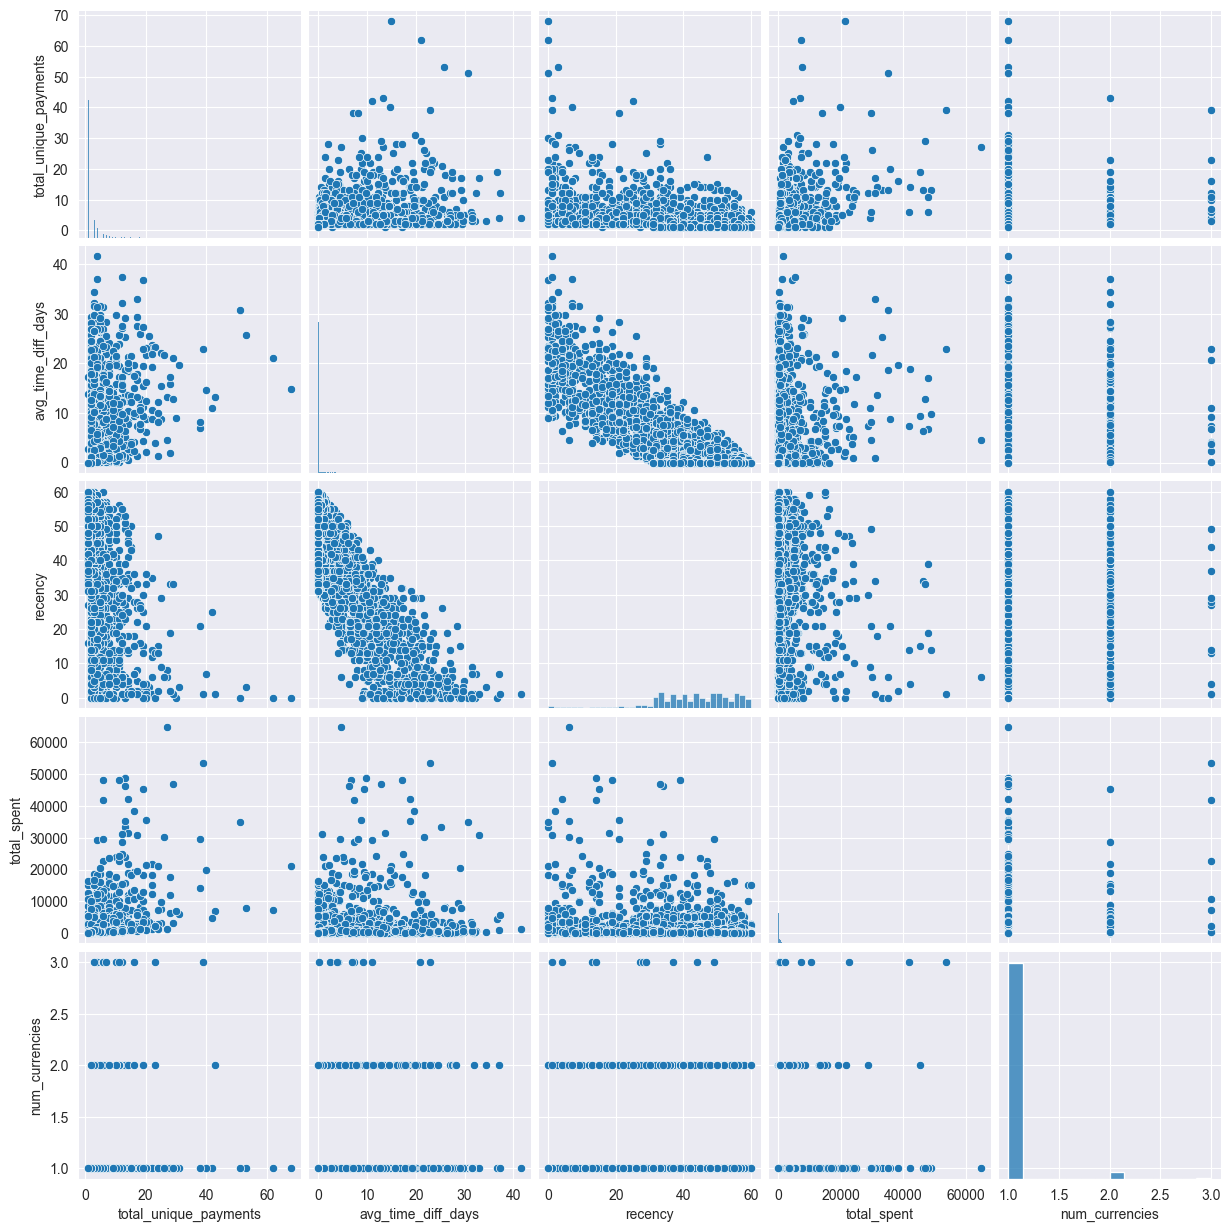

In [134]:
# Select a subset of features to avoid excessive plotting (e.g., top 5 correlated)
selected_features = X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']].corr().abs().sum().sort_values(ascending=False).index[:5]  # Select top 5 strongest correlations

# Create a pairplot for the selected features
sns.pairplot(X_train[selected_features])
plt.show()


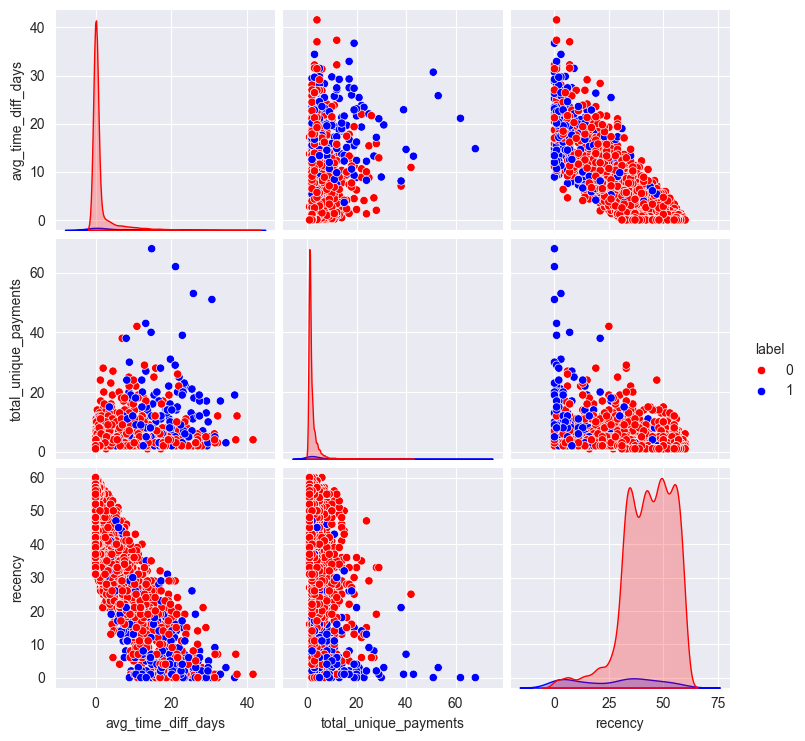

In [135]:
# pairplot with highest correlated features

df_train = pd.DataFrame(X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']], columns=X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']].columns)
df_train['label'] = y_train


sns.pairplot(df_train[['avg_time_diff_days', 'total_unique_payments', 'recency', 'label']], hue='label', palette={1: 'blue', 0: 'red'})
plt.show()

There is considerable overlap between class 0 and class 1 in each 2D combination. We don’t see separate clusters or clear boundaries; instead, both classes occupy overlapping regions, often heavily skewed.

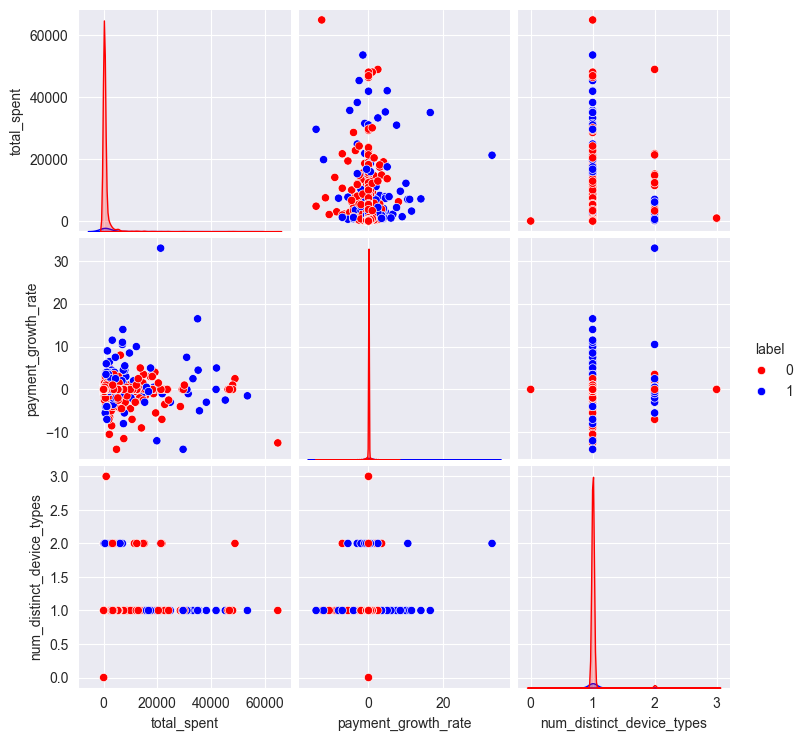

In [136]:
sns.pairplot(df_train[['total_spent', 'payment_growth_rate', 'num_distinct_device_types', 'label']], hue='label', palette={1: 'blue', 0: 'red'})
plt.show()


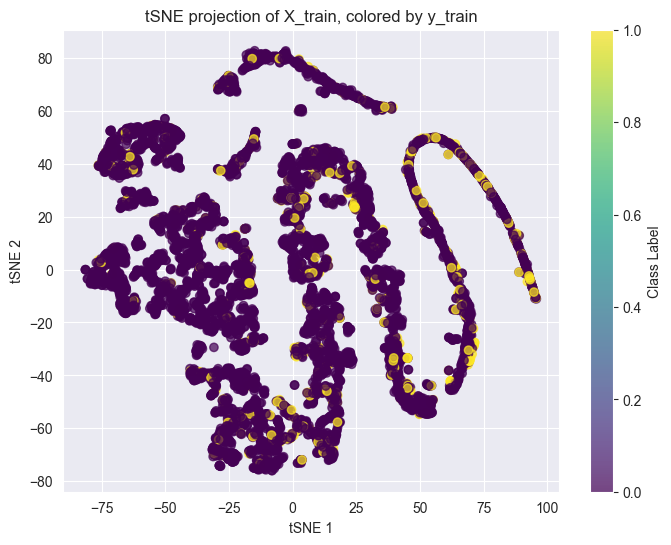

In [137]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train[['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings']])


# Then plot X_tsne[:, 0], X_tsne[:, 1] colored by y_train
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('tSNE projection of X_train, colored by y_train')
plt.colorbar(scatter, label='Class Label')
plt.show()

From the t-SNE plot we see that the positives are scattered throughout the negatives, suggesting the decision boundary is not purely linear. Therefore we will use a non-linear learner as our baseline model.

In [138]:
from scipy.stats import chi2_contingency
import pandas as pd

for col in [
    'most_common_merchant_id',
    'most_common_payment_instrument',
    'most_common_currency',
    'most_common_country',
    'most_common_device_type',
    'most_common_payment_timestamp_weekday',
    'most_common_payment_timestamp_is_weekend',
    'most_common_payment_timestamp_time_range'
]:
    # Build contingency table
    contingency = pd.crosstab(X_train[col], y_train)
    # chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"{col}: chi2={chi2:.2f}, p={p:.4f}, dof={dof},",
          "Significant" if p < 0.05 else "Not significant")


most_common_merchant_id: chi2=157.61, p=0.0000, dof=75, Significant
most_common_payment_instrument: chi2=1.40, p=0.4977, dof=2, Not significant
most_common_currency: chi2=130.99, p=0.0000, dof=55, Significant
most_common_country: chi2=212.22, p=0.0000, dof=108, Significant
most_common_device_type: chi2=11.77, p=0.0192, dof=4, Significant
most_common_payment_timestamp_weekday: chi2=8.92, p=0.1784, dof=6, Not significant
most_common_payment_timestamp_is_weekend: chi2=10.78, p=0.0010, dof=1, Significant
most_common_payment_timestamp_time_range: chi2=8.50, p=0.0367, dof=3, Significant


In [139]:
# following the chi square test we drop most_common_payment_instrument and most_common_payment_timestamp_weekday

X_train = X_train.drop(columns=['most_common_payment_instrument','most_common_payment_timestamp_weekday'])
X_dev = X_dev.drop(columns=['most_common_payment_instrument','most_common_payment_timestamp_weekday'])
X_test = X_test.drop(columns=['most_common_payment_instrument','most_common_payment_timestamp_weekday'])

In [140]:
categorical_columns = ['most_common_merchant_id', 'most_common_currency',
       'most_common_country', 'most_common_device_type',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range']
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_dev[col] = X_dev[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [141]:

from catboost import CatBoostClassifier
# Initialize CatBoost Classifier
model = CatBoostClassifier(eval_metric='Recall', cat_features=categorical_columns, verbose=100)
# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)], early_stopping_rounds=50)

Learning rate set to 0.051733
0:	learn: 0.2110656	test: 0.2110656	test1: 0.1742739	best: 0.1742739 (0)	total: 71.9ms	remaining: 1m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1742738589
bestIteration = 0

Shrink model to first 1 iterations.


In [142]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid
param_grid = {
    'eval_metric':['Recall'],
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.07, 0.1],
    'depth': [6, 8],
    'class_weights': [
        [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])], #treating class imbalance: first weight is for 0 (minority), second weight is for 1 (majority)
        None
    ],
    'random_state':[42],
    'verbose':[100]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=categorical_columns),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    scoring='recall',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit RandomizedSearchCV on the development set
random_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-p

0:	learn: 0.4631148	total: 7.25ms	remaining: 3.62s
100:	learn: 0.6024590	total: 451ms	remaining: 1.78s
200:	learn: 0.7500000	total: 895ms	remaining: 1.33s
300:	learn: 0.8913934	total: 1.36s	remaining: 902ms
400:	learn: 0.9323770	total: 1.81s	remaining: 447ms
499:	learn: 0.9692623	total: 2.28s	remaining: 0us
Best Parameters: {'verbose': 100, 'random_state': 42, 'learning_rate': 0.05, 'iterations': 500, 'eval_metric': 'Recall', 'depth': 6, 'class_weights': [1, 13.905737704918034]}
Best Recall Score: 0.4364664596430104


In [143]:
best_model_RS = random_search.best_estimator_
feature_importances = best_model_RS.get_feature_importance()
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

num_merchants: 0.42356870029539945
total_spent: 14.987900698158217
num_payment_instruments: 0.17775775469155466
num_currencies: 0.1382863026118732
avg_time_to_complete_payment: 11.796503257767393
total_unique_payments: 1.140151983184172
num_distinct_countries: 0.029492967980423127
num_distinct_states: 0.9833211117133763
num_distinct_device_types: 0.19887827208610173
avg_time_diff_days: 5.728853082100729
recency: 13.623666092430424
clumpiness: 3.529001585788271
local_currency_ratio: 1.1350282109204641
payment_growth_rate: 0.2657178256883992
total_potential_savings: 1.5499968415788339
most_common_merchant_id: 11.715920172128952
most_common_currency: 7.741750228259818
most_common_country: 9.143218297052526
most_common_device_type: 4.649925272448554
most_common_payment_timestamp_is_weekend: 1.9565254238259258
most_common_payment_timestamp_time_range: 9.084535919288623


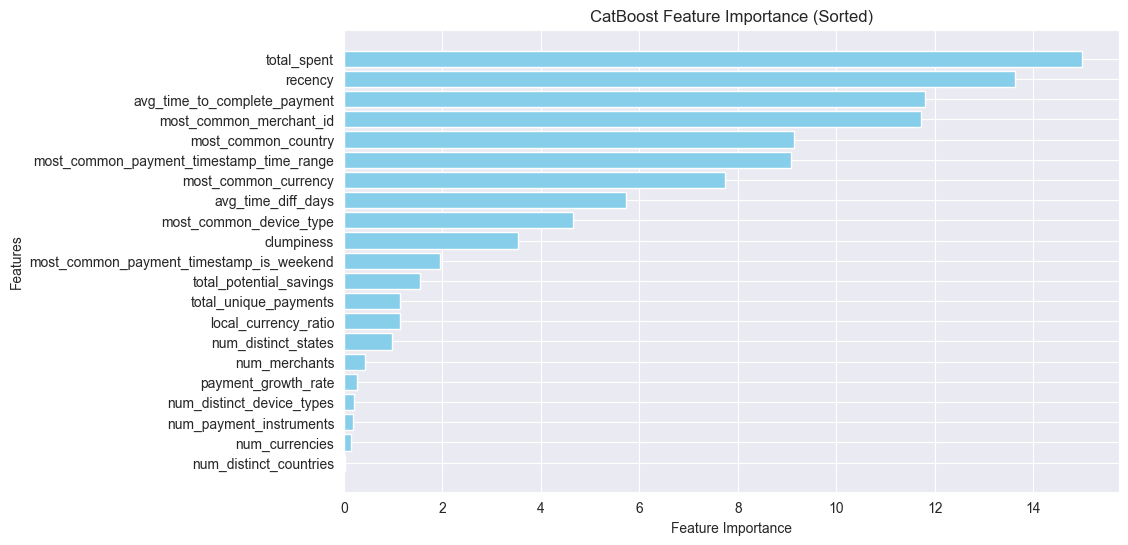

In [144]:
# Sort features and their importance values in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

In [145]:
sorted_features[:10]

Index(['total_spent', 'recency', 'avg_time_to_complete_payment',
       'most_common_merchant_id', 'most_common_country',
       'most_common_payment_timestamp_time_range', 'most_common_currency',
       'avg_time_diff_days', 'most_common_device_type', 'clumpiness'],
      dtype='object')

In [146]:
from sklearn.metrics import recall_score, confusion_matrix, classification_report
dev_preds = best_model_RS.predict(X_dev)
conf_matrix = confusion_matrix(y_dev, dev_preds)
tn, fp, fn, tp = conf_matrix.ravel()

In [147]:
fn/ (tp + fn), tp/ (tp + fn)

(0.5062240663900415, 0.49377593360995853)

From our first baseline, we see that the % of false negatives is very high out of the positives: 50% of positives are classified as negatives. These users represent a lost revenue opportunity.

In [148]:
# Predicted probabilities for the positive class
y_pred_prob = best_model_RS.predict_proba(X_dev)[:, 1]

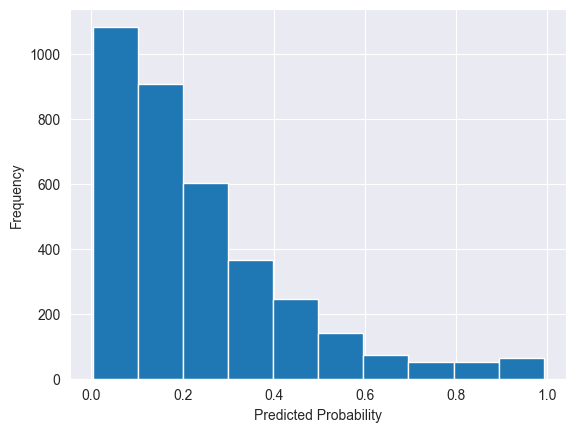

In [149]:
plt.hist(y_pred_prob)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [150]:
example_series = pd.Series(y_pred_prob)

# Use value_counts()
value_counts = example_series.value_counts()
print(value_counts)

0.373916    1
0.461507    1
0.180967    1
0.952314    1
0.027378    1
           ..
0.138578    1
0.022867    1
0.033739    1
0.262598    1
0.138531    1
Name: count, Length: 3584, dtype: int64


In [151]:
example_series.value_counts()/example_series.value_counts().sum()

0.373916    0.000279
0.461507    0.000279
0.180967    0.000279
0.952314    0.000279
0.027378    0.000279
              ...   
0.138578    0.000279
0.022867    0.000279
0.033739    0.000279
0.262598    0.000279
0.138531    0.000279
Name: count, Length: 3584, dtype: float64

In [152]:

# We want 90% of rows to be predicted '1'
desired_approval_rate = 0.9
n_samples = len(y_pred_prob)
n_positives = int(np.ceil(desired_approval_rate * n_samples))
sorted_probs_desc = np.sort(y_pred_prob)[::-1]
threshold_90 = sorted_probs_desc[n_positives - 1]

# we are taking the predicted probability above which lies 90% of the distribution
print(f"Threshold for ~{round(desired_approval_rate*100)}% positive LTV = {threshold_90:.4f}")


Threshold for ~90% positive LTV = 0.0422


In [153]:
y_pred_binary = np.where(y_pred_prob > threshold_90, 1, 0)

# Evaluate: focus on recall for the positive class
recall_rf = recall_score(y_dev, y_pred_binary, pos_label=1)

print("Catboost:")
print(f"  Recall (pos_label=1): {recall_rf:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_dev, y_pred_binary))
print("\nClassification Report Random Forest:\n", classification_report(y_dev, y_pred_binary))


Catboost:
  Recall (pos_label=1): 0.992

Confusion Matrix:
 [[ 357 2986]
 [   2  239]]

Classification Report Random Forest:
               precision    recall  f1-score   support

           0       0.99      0.11      0.19      3343
           1       0.07      0.99      0.14       241

    accuracy                           0.17      3584
   macro avg       0.53      0.55      0.17      3584
weighted avg       0.93      0.17      0.19      3584



In [154]:
cm = confusion_matrix(y_dev, y_pred_binary)

tn, fp, fn, tp = cm.ravel()

In [155]:
fn/ (tp + fn), tp/ (tp + fn)

(0.008298755186721992, 0.991701244813278)

In [156]:
fp/ (tn + fp), tn/ (tn + fp)

(0.8932096918935089, 0.10679030810649118)

let's say as a first step that we want to ensure that 90% of actual positives are predicted as 1, we need to find a threshold that does so. This means that we are ready to lose on 10% of users. I adjust the threshold to decrease the fp as well.

In [157]:
y_pred_prob = best_model_RS.predict_proba(X_dev)[:, 1]
y_pred_binary = np.where(y_pred_prob > 0.0996, 1, 0)
cm = confusion_matrix(y_dev, y_pred_binary)

tn, fp, fn, tp = cm.ravel()

In [158]:
fn/ (tp + fn), tp/ (tp + fn)

(0.06639004149377593, 0.9336099585062241)

In [159]:
fp/ (tn + fp), tn/ (tn + fp)

(0.6883039186359557, 0.31169608136404425)

So we managed to decrease both FN and FP: we have 6% FN instead of 50%. But what's the cost of this?

In [160]:
df_dev = X_dev.copy()
df_dev['label_dev'] = y_dev
df_dev['pred_dev_binary_rf'] = y_pred_binary
df_dev['pred_dev_prob_rf'] = y_pred_prob
df_dev['total_spent_label_dev'] = final_dataset[final_dataset.index.isin(X_dev.index)].total_spent_label

In [161]:
df_dev[(df_dev.label_dev == 1) & (df_dev.pred_dev_binary_rf == 0)].total_spent_label_dev.describe()

count      16.000000
mean      335.663125
std       839.639924
min        30.000000
25%        50.367500
50%        71.060000
75%       182.580000
max      3446.890000
Name: total_spent_label_dev, dtype: float64

The FN on average for 3 months of LTV would cost us 335 USD.

### Regression model on positive LTVs

In [162]:
df_positive_LTV = final_dataset[final_dataset.total_spent_label > 0]

In [163]:
df_positive_LTV.head()

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,...,most_common_merchant_id,most_common_payment_instrument,most_common_currency,most_common_country,most_common_device_type,most_common_payment_timestamp_weekday,most_common_payment_timestamp_is_weekend,most_common_payment_timestamp_time_range,total_spent_label,total_spent_label_binary
19,11008878,1,663.00,1,1,2.659604,10,1,1,1,...,626,credit_card,USD,US,mobile,Saturday,1,Night,60.00,1
37,11009032,1,30.00,1,1,0.801134,1,1,1,1,...,160,credit_card,USD,US,mobile,Saturday,1,Night,30.00,1
132,11009577,1,90.00,1,1,1.654866,3,1,1,1,...,288,credit_card,USD,US,mobile,Friday,0,Morning,150.00,1
257,11010133,2,10542.03,1,1,2.507851,27,1,0,1,...,593,credit_card,GBP,GB,mobile,Monday,0,Afternoon,16529.26,1
265,11010175,1,112.28,1,1,6.237068,1,1,0,1,...,68,credit_card,USD,DE,mobile,Saturday,1,Afternoon,435.00,1


In [164]:
df_positive_LTV_train = df_positive_LTV[df_positive_LTV.index.isin(X_train.index)]
df_positive_LTV_dev = df_positive_LTV[df_positive_LTV.index.isin(X_dev.index)]

In [165]:
df_positive_LTV_train.shape, X_train.shape, df_positive_LTV_dev.shape, X_dev.shape

((488, 26), (7274, 21), (241, 26), (3584, 21))

In [166]:
df_positive_LTV_train.columns

Index(['user_id', 'num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings',
       'most_common_merchant_id', 'most_common_payment_instrument',
       'most_common_currency', 'most_common_country',
       'most_common_device_type', 'most_common_payment_timestamp_weekday',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range', 'total_spent_label',
       'total_spent_label_binary'],
      dtype='object')

In [167]:
X_train.columns

Index(['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings',
       'most_common_merchant_id', 'most_common_currency',
       'most_common_country', 'most_common_device_type',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range'],
      dtype='object')

In [168]:
df_positive_LTV_train_X = df_positive_LTV_train[X_train.columns]
df_positive_LTV_train_y = df_positive_LTV_train['total_spent_label']

df_positive_LTV_dev_X = df_positive_LTV_dev[X_dev.columns]
df_positive_LTV_dev_y = df_positive_LTV_dev['total_spent_label']

In [169]:
df_positive_LTV_train_X.shape, len(df_positive_LTV_train_y), df_positive_LTV_dev_X.shape, len(df_positive_LTV_dev_y)

((488, 21), 488, (241, 21), 241)

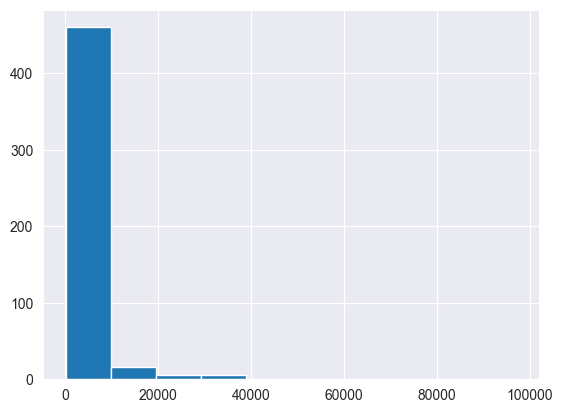

In [170]:
plt.hist(df_positive_LTV_train_y)
plt.show()

In [171]:
df_positive_LTV_train_y.describe()

count      488.000000
mean      2293.912807
std       6811.242080
min         30.000000
25%        110.000000
50%        399.315000
75%       1399.517500
max      97116.230000
Name: total_spent_label, dtype: float64

the label is still very skewed but this time is strictly positive. Let's see what happens if i transform it by taking the logarithm.

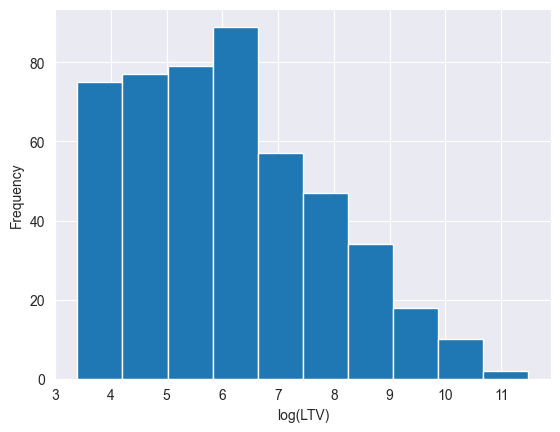

In [172]:
plt.hist(np.log(df_positive_LTV_train_y))
plt.xlabel('log(LTV)')
plt.ylabel('Frequency')
plt.show()

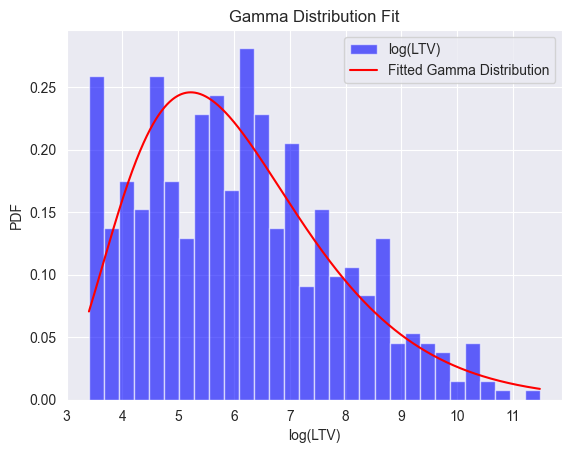

In [173]:
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

# Fit a gamma distribution to the data
shape, loc, scale = gamma.fit(np.log(df_positive_LTV_train_y))

# Generate x values for plotting the fitted curve
x = np.linspace(np.log(df_positive_LTV_train_y).min(), np.log(df_positive_LTV_train_y).max(), 1000)
fitted_pdf = gamma.pdf(x, shape, loc, scale)

# Plot the histogram and the fitted gamma distribution
plt.hist(np.log(df_positive_LTV_train_y), bins=30, density=True, alpha=0.6, color='blue', label='log(LTV)')
plt.plot(x, fitted_pdf, 'r-', label='Fitted Gamma Distribution')
plt.xlabel('log(LTV)')
plt.ylabel('PDF')
plt.legend()
plt.title("Gamma Distribution Fit")
plt.show()


In [174]:
from scipy.stats import kstest

# Perform the K-S test
ks_statistic, p_value = kstest(np.log(df_positive_LTV_train_y), 'gamma', args=(shape, loc, scale))

print(f"K-S Statistic: {ks_statistic:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value > 0.05:
    print("Fail to reject the null hypothesis: The data follows a gamma distribution.")
else:
    print("Reject the null hypothesis: The data does not follow a gamma distribution.")


K-S Statistic: 0.0452
P-Value: 0.2633
Fail to reject the null hypothesis: The data follows a gamma distribution.


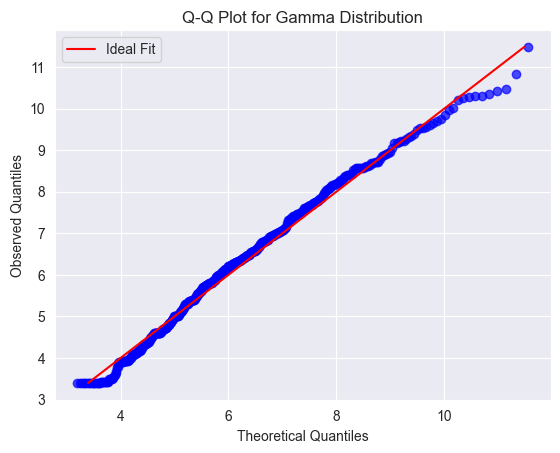

In [175]:
import scipy.stats as stats

# Generate theoretical quantiles
gamma_quantiles = gamma.ppf(np.linspace(0.01, 0.99, len(np.log(df_positive_LTV_train_y))), shape, loc, scale)

# Sort the observed data
observed_data_sorted = np.sort(np.log(df_positive_LTV_train_y))

# Plot the Q-Q plot
plt.scatter(gamma_quantiles, observed_data_sorted, alpha=0.7, color='blue')
plt.plot([observed_data_sorted.min(), observed_data_sorted.max()],
         [observed_data_sorted.min(), observed_data_sorted.max()], 'r-', label='Ideal Fit')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Observed Quantiles")
plt.legend()
plt.title("Q-Q Plot for Gamma Distribution")
plt.show()


we can see that when we take the log of y_train, the label follows a gamma distribution (statistically significant kolmogorov smirnov test and Q-Q plot).

In [176]:
df_positive_LTV_train['log_total_spent_label'] = np.log(df_positive_LTV_train['total_spent_label'])
df_positive_LTV_dev['log_total_spent_label'] = np.log(df_positive_LTV_dev['total_spent_label'])

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/2268072504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive_LTV_train['log_total_spent_label'] = np.log(df_positive_LTV_train['total_spent_label'])
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/2268072504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive_LTV_dev['log_total_spent_label'] = np.log(df_positive_LTV_dev['total_spent_label'])


In [177]:
df_positive_LTV_train_X = df_positive_LTV_train[X_train.columns]
df_positive_LTV_train_y = df_positive_LTV_train['log_total_spent_label']

df_positive_LTV_dev_X = df_positive_LTV_dev[X_dev.columns]
df_positive_LTV_dev_y = df_positive_LTV_dev['log_total_spent_label']

In [178]:
# Ensure y_train is a DataFrame and concatenate it with X_train
corr_matrix = df_positive_LTV_train[['num_merchants', 'total_spent', 'num_currencies',
       'avg_time_to_complete_payment', 'total_unique_payments',
       'num_distinct_countries', 'num_distinct_states',
       'num_distinct_device_types', 'avg_time_diff_days', 'recency',
       'clumpiness', 'local_currency_ratio', 'payment_growth_rate',
       'total_potential_savings','log_total_spent_label']].corr()


np.abs(corr_matrix['log_total_spent_label'])

num_merchants                   0.150699
total_spent                     0.511059
num_currencies                  0.128260
avg_time_to_complete_payment    0.042802
total_unique_payments           0.468458
num_distinct_countries          0.033598
num_distinct_states             0.059489
num_distinct_device_types       0.026015
avg_time_diff_days              0.369903
recency                         0.411977
clumpiness                      0.314958
local_currency_ratio            0.043128
payment_growth_rate             0.165880
total_potential_savings         0.127424
log_total_spent_label           1.000000
Name: log_total_spent_label, dtype: float64

The top 5 features that are highly correlated with the logLTV during august-october are:
- the total_spent(usd) per user during june and july: the higher the total spent in june-july, the higher the LTV
- the total number of unique payments: the higher the number of payments, the higher the LTV
- recency: the lower the recency the higher the predicted LTV
- avg_time_diff_days: the average time from the first approved payment.
- clumpiness: are payments concetrated in the same day: the more payments are concentrated in the same day, the higher the LTV


In [179]:
df_positive_LTV_train[['num_merchants', 'total_spent', 'num_currencies',
       'avg_time_to_complete_payment', 'total_unique_payments',
       'num_distinct_countries', 'num_distinct_states',
       'num_distinct_device_types', 'avg_time_diff_days', 'recency',
       'clumpiness', 'local_currency_ratio', 'payment_growth_rate',
       'total_potential_savings']].corr()

,num_merchants,total_spent,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,avg_time_diff_days,recency,clumpiness,local_currency_ratio,payment_growth_rate,total_potential_savings
num_merchants,1.000000,0.117038,0.016498,-0.027493,0.257986,0.135304,0.071261,0.280438,0.155384,-0.196816,0.190946,0.061876,0.198350,0.055448
total_spent,0.117038,1.000000,0.238560,-0.034597,0.530457,0.032435,0.014436,-0.006064,0.273516,-0.298630,0.401351,0.044786,0.124571,0.116299
num_currencies,0.016498,0.238560,1.000000,-0.030088,0.126532,0.102988,-0.182752,0.154474,0.178876,-0.181195,0.084950,-0.196017,-0.015793,0.081869
avg_time_to_complete_payment,-0.027493,-0.034597,-0.030088,1.000000,-0.062347,-0.011314,-0.063939,0.002407,-0.082723,0.083172,-0.050050,-0.003455,-0.012067,-0.018127
total_unique_payments,0.257986,0.530457,0.126532,-0.062347,1.000000,-0.011117,0.173875,0.135009,0.475660,-0.505447,0.539429,0.115321,0.430151,0.098734
num_distinct_countries,0.135304,0.032435,0.102988,-0.011314,-0.011117,1.000000,-0.069087,0.060496,0.019741,-0.056182,0.001320,-0.078707,-0.035445,0.148955
num_distinct_states,0.071261,0.014436,-0.182752,-0.063939,0.173875,-0.069087,1.000000,-0.002828,0.067890,-0.110943,0.135508,0.284326,0.106344,-0.089680
num_distinct_device_types,0.280438,-0.006064,0.154474,0.002407,0.135009,0.060496,-0.002828,1.000000,0.132875,-0.162288,0.042704,0.005044,0.109209,0.024318
avg_time_diff_days,0.155384,0.273516,0.178876,-0.082723,0.475660,0.019741,0.067890,0.132875,1.000000,-0.847584,0.156153,0.081495,0.235920,0.066754
recency,-0.196816,-0.298630,-0.181195,0.083172,-0.505447,-0.056182,-0.110943,-0.162288,-0.847584,1.000000,-0.196507,-0.088244,-0.218465,-0.080693


In [180]:
# we can see that avg_time_diff_days and recency are highly correlated, so we generate an interaction variable and drop both

df_positive_LTV_train_X['interaction_diffdays_recency'] = df_positive_LTV_train_X['avg_time_diff_days'] * df_positive_LTV_train_X['recency']
df_positive_LTV_dev_X['interaction_diffdays_recency'] = df_positive_LTV_dev_X['avg_time_diff_days'] * df_positive_LTV_dev_X['recency']

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/1916406963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive_LTV_train_X['interaction_diffdays_recency'] = df_positive_LTV_train_X['avg_time_diff_days'] * df_positive_LTV_train_X['recency']
/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/1916406963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive_LTV_dev_X['interaction_diffdays_recency'] = df_positive_LTV_dev_X['avg_time_diff_days'] * df_positive_L

In [181]:
df_positive_LTV_train_X = df_positive_LTV_train_X.drop(columns=['avg_time_diff_days', 'recency'])
df_positive_LTV_dev_X = df_positive_LTV_dev_X.drop(columns=['avg_time_diff_days', 'recency'])

In [182]:
df_positive_LTV_train_X.columns

Index(['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types', 'clumpiness',
       'local_currency_ratio', 'payment_growth_rate',
       'total_potential_savings', 'most_common_merchant_id',
       'most_common_currency', 'most_common_country',
       'most_common_device_type', 'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range',
       'interaction_diffdays_recency'],
      dtype='object')

In [183]:
X_train.columns

Index(['num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types',
       'avg_time_diff_days', 'recency', 'clumpiness', 'local_currency_ratio',
       'payment_growth_rate', 'total_potential_savings',
       'most_common_merchant_id', 'most_common_currency',
       'most_common_country', 'most_common_device_type',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range'],
      dtype='object')

In [184]:
from scipy.stats import kruskal

catg = ['most_common_merchant_id', 'most_common_currency',
       'most_common_country', 'most_common_device_type',
       'most_common_payment_timestamp_is_weekend',
       'most_common_payment_timestamp_time_range']


for c in catg:
    groups = []
    for cat_value in df_positive_LTV_train[c].unique():
        groups.append(df_positive_LTV_train.loc[df_positive_LTV_train[c] == cat_value, 'log_total_spent_label'].values)

    stat, p_value = kruskal(*groups)
    if p_value < 0.05:
        print(c)
        print("Kruskal-Wallis statistic:", stat)
        print("p-value:", p_value)


most_common_merchant_id
Kruskal-Wallis statistic: 93.56043710640657
p-value: 2.2207611015130582e-06
most_common_device_type
Kruskal-Wallis statistic: 10.293257592367242
p-value: 0.016230977279769503
most_common_payment_timestamp_is_weekend
Kruskal-Wallis statistic: 13.373234421344307
p-value: 0.0002552407948454857


In [185]:
# Following the kruskal wallis test we drop also the following:

df_positive_LTV_train_X = df_positive_LTV_train_X.drop(columns = ['most_common_currency', 'most_common_country','most_common_payment_timestamp_time_range'])
df_positive_LTV_dev_X = df_positive_LTV_dev_X.drop(columns = ['most_common_currency', 'most_common_country','most_common_payment_timestamp_time_range'])

In [211]:
# Evaluation metrics
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [212]:
import pandas as pd
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_gamma_deviance

# Step 1: Define numerical and categorical features
numerical_features = [
    'num_merchants', 'total_spent', 'num_payment_instruments',
       'num_currencies', 'avg_time_to_complete_payment',
       'total_unique_payments', 'num_distinct_countries',
       'num_distinct_states', 'num_distinct_device_types', 'clumpiness',
       'local_currency_ratio', 'payment_growth_rate',
       'total_potential_savings', 'interaction_diffdays_recency'
]
categorical_features = ['most_common_merchant_id',
       'most_common_device_type', 'most_common_payment_timestamp_is_weekend']

# Step 2: Define preprocessing steps
# One-hot encode categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scale numerical variables
numerical_transformer = StandardScaler()

# Combine preprocessors into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# Step 3: Create the Tweedie Regressor pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TweedieRegressor(power=1.99, alpha=0.3, max_iter=1000))
])

# Step 5: Fit the model
model.fit(df_positive_LTV_train_X, df_positive_LTV_train_y)

# Step 6: Make Predictions
y_train_pred = model.predict(df_positive_LTV_train_X)
y_dev_pred = model.predict(df_positive_LTV_dev_X)

# Step 7: Evaluate the model
train_rmse = mean_squared_error(df_positive_LTV_train_y, y_train_pred, squared=False)
train_gamma_deviance = mean_gamma_deviance(df_positive_LTV_train_y, y_train_pred)
train_rmsle = rmsle(df_positive_LTV_train_y, y_train_pred)

dev_rmse = mean_squared_error(df_positive_LTV_dev_y, y_dev_pred, squared=False)
dev_gamma_deviance = mean_gamma_deviance(df_positive_LTV_dev_y, y_dev_pred)
dev_rmsle = rmsle(df_positive_LTV_dev_y, y_dev_pred)


print('Log scale metrics')

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Dev RMSLE: {dev_rmsle:.4f}")

print(f"Train Gamma Deviance: {train_gamma_deviance:.4f}")
print(f"Dev Gamma Deviance: {dev_gamma_deviance:.4f}")

# Step 4: Apply the inverse transformation (back to original scale)
y_train_pred_original = np.exp(y_train_pred)
y_dev_pred_original = np.exp(y_dev_pred)

# Step 7: Evaluate the model
train_rmse = mean_squared_error(df_positive_LTV_train.total_spent_label, y_train_pred_original, squared=False)
train_gamma_deviance = mean_gamma_deviance(df_positive_LTV_train.total_spent_label, y_train_pred_original)
train_rmsle = rmsle(df_positive_LTV_train.total_spent_label, y_train_pred_original)

dev_rmse = mean_squared_error(df_positive_LTV_dev.total_spent_label, y_dev_pred_original, squared=False)
dev_gamma_deviance = mean_gamma_deviance(df_positive_LTV_dev.total_spent_label, y_dev_pred_original)
dev_rmsle = rmsle(df_positive_LTV_dev.total_spent_label, y_dev_pred_original)


print('Original scale metrics')

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Dev RMSLE: {dev_rmsle:.4f}")

print(f"Train Gamma Deviance: {train_gamma_deviance:.4f}")
print(f"Dev Gamma Deviance: {dev_gamma_deviance:.4f}")


Log scale metrics
Train RMSLE: 0.2031
Dev RMSLE: 0.2116
Train Gamma Deviance: 0.0560
Dev Gamma Deviance: 0.0610
Original scale metrics
Train RMSLE: 1.4096
Dev RMSLE: 1.4590
Train Gamma Deviance: 3.7927
Dev Gamma Deviance: 4.4002


/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michaelbenmergui/Documents/Gioia/PycharmProjects/data-wizard-gioia/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/michae

1. Log Scale Metrics (Log-transformed label)
- Train RMSLE  vs Dev RMSLE : Root Mean Squared Logarithmic Error (RMSLE) penalizes large relative differences. The values are low, suggesting the model captures relative changes between predictions and actual values well. The small gap between train and dev RMSLE shows that the model is not overfitting significantly.
- Train Gamma Deviance  vs Dev Gamma Deviance : Gamma deviance values are small, indicating the model fits well in the gamma distribution space. The small difference between train and dev shows good generalization.

2. Original Scale Metrics (Exponentiated label)
- Train RMSLE  vs Dev RMSLE : RMSLE is consistent between train and dev, suggesting the model captures relative changes in LTV well even on the original scale.
- Train Gamma Deviance vs Dev Gamma Deviance : These values are larger than the log scale gamma deviance, which is expected since the original scale has more variance. The gap between train and dev gamma deviance is moderate, suggesting the model captures the gamma distribution reasonably well, but there might be room for improvement.

Key Insights:
- Generalization: The metrics on the log scale (RMSLE, Gamma Deviance) show small differences between train and dev, indicating good generalization.
The slightly larger gap in original scale metrics (Train RMSLE vs Dev RMSLE) might indicate the model is struggling with the wide range of LTV values on the original scale.
- Scale of Error: On the original scale, the RMSLE and Gamma Deviance are high, suggesting the model struggles with absolute errors, especially for large LTV values. This is due to the skewness of the original LTV distribution.
- Model Performance: The model performs well in relative terms (RMSLE and Gamma Deviance on the log scale), indicating it captures proportional relationships effectively. However, absolute accuracy on the original scale is less reliable, due to high variance and outliers in the LTV data.

Conclusion:
The model performs reasonably well on the log-transformed scale but struggles on the original scale, likely due to the high variance and skewness of the LTV distribution.



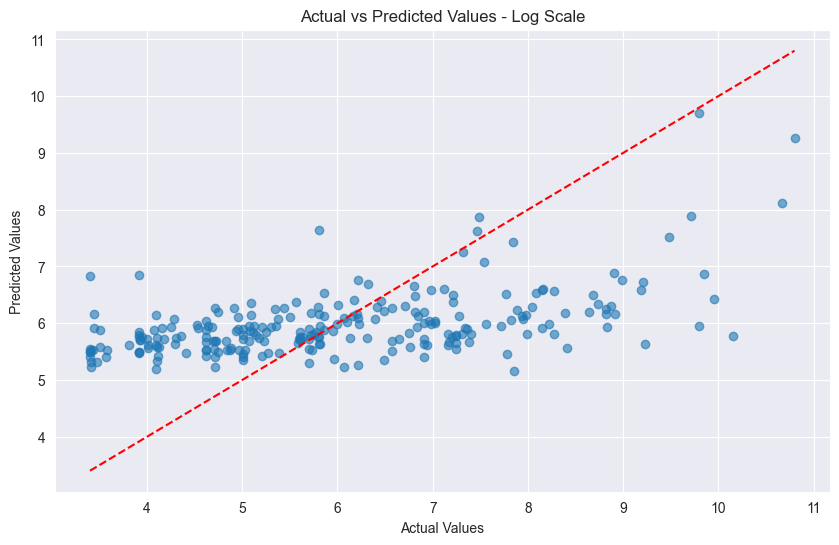

In [213]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(df_positive_LTV_dev_y, y_dev_pred, alpha=0.6)
plt.plot([min(df_positive_LTV_dev_y), max(df_positive_LTV_dev_y)], [min(df_positive_LTV_dev_y), max(df_positive_LTV_dev_y)], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Log Scale')
plt.show()

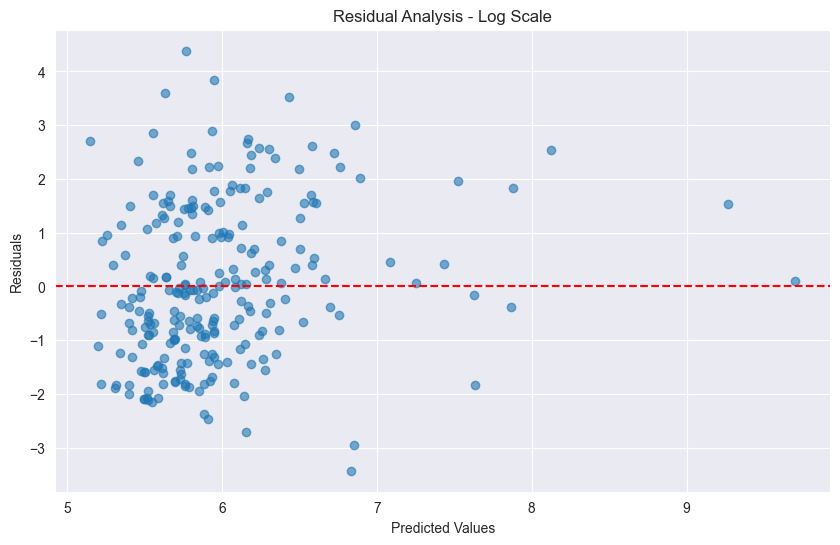

In [214]:
# Residual plot
residuals = df_positive_LTV_dev_y - y_dev_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_dev_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis - Log Scale')
plt.show()

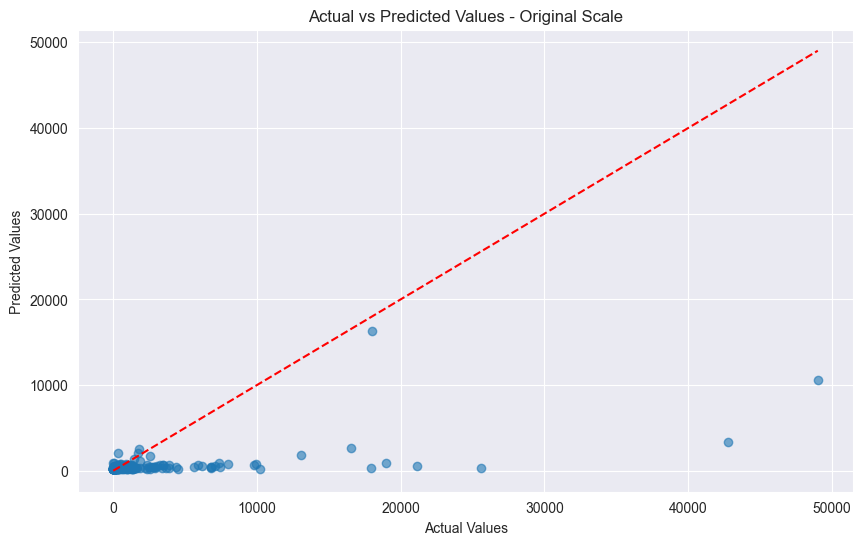

In [215]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(df_positive_LTV_dev.total_spent_label, y_dev_pred_original, alpha=0.6)
plt.plot([min(df_positive_LTV_dev.total_spent_label), max(df_positive_LTV_dev.total_spent_label)], [min(df_positive_LTV_dev.total_spent_label), max(df_positive_LTV_dev.total_spent_label)], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Original Scale')
plt.show()

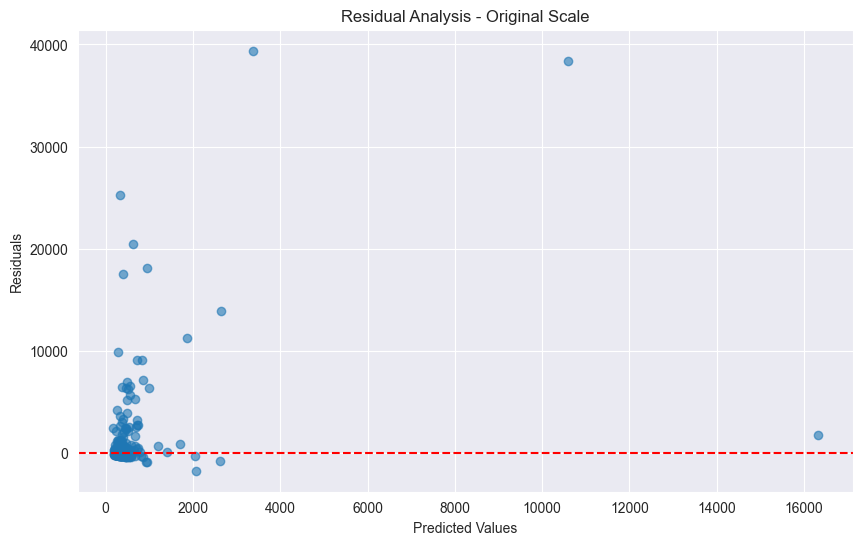

In [216]:

# Residual plot
residuals = df_positive_LTV_dev.total_spent_label - y_dev_pred_original
plt.figure(figsize=(10, 6))
plt.scatter(y_dev_pred_original, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis - Original Scale')
plt.show()

### now let's predict for the test set

In [217]:
# classification
y_pred_prob = best_model_RS.predict_proba(X_test)[:, 1]
y_pred_binary = np.where(y_pred_prob > 0.0996, 1, 0)

In [ ]:
#regression

df_positive_LTV_test = final_dataset[final_dataset.index.isin(X_test.index)]
df_positive_LTV_test['log_total_spent_label'] = np.log(df_positive_LTV_test['total_spent_label'])
df_positive_LTV_test_X = df_positive_LTV_test[X_test.columns]
df_positive_LTV_test_X['interaction_diffdays_recency'] = df_positive_LTV_test_X['avg_time_diff_days'] * df_positive_LTV_test_X['recency']
df_positive_LTV_test_X = df_positive_LTV_test_X.drop(columns=['avg_time_diff_days', 'recency'])
df_positive_LTV_test_X = df_positive_LTV_test_X.drop(columns = ['most_common_currency', 'most_common_country','most_common_payment_timestamp_time_range'])
y_pred_test = model.predict(df_positive_LTV_test_X)
y_test_pred_original = np.exp(y_pred_test)

In [223]:
# combine regression and classification
y_pred_test_final = y_pred_binary * y_test_pred_original
y_test = df_positive_LTV_test['total_spent_label']
df_test_final = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred_test_final})

In [225]:
df_test_final.corr()

,y_test,y_pred
y_test,1.000000,0.575672
y_pred,0.575672,1.000000


Predictions are reasonably aligned with actual values: the model captures meaningful patterns in the data but there is room for improvement. Let's see who are these users and how can nuvei leverage them to increase revenue.

# Analytics on the test set

In [227]:
test_df = final_dataset[final_dataset.index.isin(X_test.index)]
test_df['pred'] = y_pred_test_final

/var/folders/tz/4zg0f6x90m7cbq4q1p10p1m40000gn/T/ipykernel_40889/4249038711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred_test_final


In [228]:
test_df.sort_values(by='pred', ascending=False)

,user_id,num_merchants,total_spent,num_payment_instruments,num_currencies,avg_time_to_complete_payment,total_unique_payments,num_distinct_countries,num_distinct_states,num_distinct_device_types,...,most_common_payment_instrument,most_common_currency,most_common_country,most_common_device_type,most_common_payment_timestamp_weekday,most_common_payment_timestamp_is_weekend,most_common_payment_timestamp_time_range,total_spent_label,total_spent_label_binary,pred
10651,11062232,1,59157.00,1,1,3.057417,104,1,0,1,...,credit_card,EUR,CI,mobile,Monday,0,Morning,100295.45,1,1.445975e+30
4680,11031911,3,57067.00,1,1,1.269898,99,1,1,2,...,credit_card,USD,US,mobile,Tuesday,0,Morning,107521.90,1,2.984979e+09
8458,11051121,6,50856.57,1,1,1.489820,47,1,1,1,...,credit_card,USD,US,mobile,Friday,0,Night,0.00,0,2.270677e+07
4004,11028168,2,44483.68,1,1,1.162585,74,1,0,1,...,credit_card,GBP,GB,mobile,Thursday,0,Evening,7768.37,1,9.961082e+05
10345,11060763,1,4142.00,1,1,1.346108,89,1,1,1,...,credit_card,USD,US,mobile,Thursday,0,Evening,5313.00,1,1.365715e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,11035232,1,49.44,1,1,3.021318,1,1,0,1,...,credit_card,EUR,SK,mobile,Monday,0,Morning,0.00,0,0.000000e+00
5282,11035253,1,191.06,1,1,6.411179,2,1,0,1,...,credit_card,JPY,JP,mobile,Monday,0,Morning,0.00,0,0.000000e+00
11815,11068419,1,1327.46,1,2,5.251240,4,1,0,1,...,credit_card,NOK,NO,pc,Tuesday,0,Afternoon,2455.94,1,0.000000e+00
5293,11035301,1,1270.07,1,1,6.694736,1,1,0,1,...,credit_card,GBP,GB,pc,Monday,0,Morning,0.00,0,0.000000e+00


In [229]:
test_df['pred'].describe()

count    5.348000e+03
mean     2.703767e+26
std      1.977265e+28
min      0.000000e+00
25%      0.000000e+00
50%      2.502361e+02
75%      3.203753e+02
max      1.445975e+30
Name: pred, dtype: float64

In [239]:
# let's see who are the users whose predicted LTV is in the upper quartile - these are the most lucrative users

most_lucrative = test_df[test_df['pred']>=3.203753e+02]

In [235]:
# what about those users who are the lease lucrative?

least_lucrative = test_df[test_df['pred']<= 2.502361e+02]

In [242]:
def test_analitycs(df):
    average_num_merchants = df.num_merchants.mean()
    average_tot_spent_july_june = df.total_spent.mean()
    average_time_to_complete_payment = df.avg_time_to_complete_payment.mean()
    average_number_of_payments = df.total_unique_payments.mean()
    avg_recency = df.recency.mean()
    avg_clumpiness = df.clumpiness.mean()
    most_common_merchant = df['most_common_merchant_id'].mode()[0]
    most_common_payment_instrument = df['most_common_payment_instrument'].mode()[0]
    most_common_currency = df['most_common_currency'].mode()[0]
    most_common_country = df['most_common_country'].mode()[0]
    most_common_device_type = df['most_common_device_type'].mode()[0]
    most_common_weekday = df['most_common_payment_timestamp_weekday'].mode()[0]
    most_common_time_range = df['most_common_payment_timestamp_time_range'].mode()[0]
    print(f'average_num_merchants={average_num_merchants}')
    print(f'average_tot_spent_july_june={average_tot_spent_july_june}')
    print(f'average_time_to_complete_payment={average_time_to_complete_payment}')
    print(f'average_number_of_payments={average_number_of_payments}')
    print(f'avg_recency={avg_recency}')
    print(f'avg_clumpiness={avg_clumpiness}')
    print(f'most_common_payment_instrument={most_common_payment_instrument}')
    print(f'most_common_merchant={most_common_merchant}')
    print(f'most_common_currency={most_common_currency}')
    print(f'most_common_country={most_common_country}')
    print(f'most_common_device_type={most_common_device_type}')
    print(f'most_common_weekday={most_common_weekday}')
    print(f'most_common_time_range={most_common_time_range}')



In [243]:
test_analitycs(df=most_lucrative)

average_num_merchants=1.0762902019446523
average_tot_spent_july_june=2068.308526551982
average_time_to_complete_payment=9.176951556127621
average_number_of_payments=4.091997008227374
avg_recency=37.31787584143605
avg_clumpiness=1.5717740724090874
most_common_payment_instrument=credit_card
most_common_merchant=602
most_common_currency=EUR
most_common_country=US
most_common_device_type=mobile
most_common_weekday=Friday
most_common_time_range=Afternoon


In [244]:
test_analitycs(df=least_lucrative)

average_num_merchants=1.0149588631264024
average_tot_spent_july_june=530.2136761406133
average_time_to_complete_payment=26.15270157420663
average_number_of_payments=1.718773373223635
avg_recency=43.31899775617053
avg_clumpiness=1.1348047676581707
most_common_payment_instrument=credit_card
most_common_merchant=288
most_common_currency=EUR
most_common_country=US
most_common_device_type=mobile
most_common_weekday=Saturday
most_common_time_range=Afternoon


There are some insights that could be useful for targeting these users:
- most lucrative users are those user whose in the observation window spend 4 times more (around 2000USD on avg vs 530 of least lucrative)
- the average time to complete payment of most lucrative users is 3 times less - around 9 seconds vs 26 seconds of least lucratives.
- lucrative users (high predicted LTV for august-october) do 4 times more payments then least lucrative.

In [246]:
df_features_with_pred = pd.merge(df_features[df_features.user_id.isin(test_df.user_id)], test_df[['user_id','pred']], how='left', on='user_id')

In [249]:
df_features_with_pred.head()

,payment_id,user_id,merchant_id,payment_timestamp,first_approved_payment_timestamp,total_amount_usd,payment_instrument,currency,time_to_complete_payment,num_approved_payments_per_user,...,time_diff_days,last_payment_month,recency,official_currency,is_paying_in_local_currency,first_approved_payment_month,is_observation,is_label,potential_savings,pred
0,66675434,11008768,248,2024-06-01 00:07:00,2024-06-01 00:07:00,150.00,credit_card,USD,3.431595,1,...,0.0,6,4,USD,1,6,True,False,0.0,248.031496
1,66675492,11008775,288,2024-06-01 00:12:00,2024-06-01 00:12:00,30.00,credit_card,USD,1.600267,1,...,0.0,6,4,USD,1,6,True,False,0.0,191.034558
2,66675558,11008784,160,2024-06-01 00:18:00,2024-06-01 00:18:00,41.42,credit_card,EUR,2.335492,1,...,0.0,7,3,EUR,1,6,True,False,0.0,0.000000
3,66675589,11008787,265,2024-06-01 00:21:00,2024-06-01 00:21:00,101.19,credit_card,EUR,2.959527,1,...,0.0,6,4,EUR,1,6,True,False,0.0,251.091563
4,66675624,11008795,288,2024-06-01 00:23:00,2024-06-01 00:23:00,32.57,credit_card,EUR,7.543811,1,...,0.0,6,4,EUR,1,6,True,False,0.0,471.148902


In [250]:
# Define high and low LTV segments per merchant
df_features_with_pred['q3'] = df_features_with_pred.groupby('merchant_id')['pred'].transform(lambda x: x.quantile(0.75))
df_features_with_pred['q1'] = df_features_with_pred.groupby('merchant_id')['pred'].transform(lambda x: x.quantile(0.25))

df_features_with_pred['LTV_segment'] = np.where(
    df_features_with_pred['pred'] >= df_features_with_pred['q3'], 'High_LTV',
    np.where(df_features_with_pred['pred'] <= df_features_with_pred['q1'], 'Low_LTV', 'Medium_LTV')
)

# Keep only high and low segments
df_high_low_LTV = df_features_with_pred[df_features_with_pred['LTV_segment'].isin(['High_LTV', 'Low_LTV'])]


In [252]:
# Aggregate characteristics for High and Low LTV users per merchant_id
grouped_features = df_high_low_LTV.groupby(['merchant_id', 'LTV_segment']).agg({
    'payment_instrument': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'currency': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'is_paying_in_local_currency': lambda x: x.mean(),  # Percentage paying in local currency
    'country': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'state': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'device_type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'payment_timestamp_weekday': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'payment_timestamp_season': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'payment_timestamp_time_range': lambda x: x.mode()[0] if not x.mode().empty else np.nan
}).reset_index()


In [253]:
# Pivot the results to compare High and Low LTV side-by-side
high_ltv = grouped_features[grouped_features['LTV_segment'] == 'High_LTV'].set_index('merchant_id')
low_ltv = grouped_features[grouped_features['LTV_segment'] == 'Low_LTV'].set_index('merchant_id')

# Merge to compare high vs. low LTV segments
comparison = high_ltv.merge(low_ltv, on='merchant_id', suffixes=('_high', '_low'))

comparison

,LTV_segment_high,payment_instrument_high,currency_high,is_paying_in_local_currency_high,country_high,state_high,device_type_high,payment_timestamp_weekday_high,payment_timestamp_season_high,payment_timestamp_time_range_high,LTV_segment_low,payment_instrument_low,currency_low,is_paying_in_local_currency_low,country_low,state_low,device_type_low,payment_timestamp_weekday_low,payment_timestamp_season_low,payment_timestamp_time_range_low
merchant_id,,,,,,,,,,,,,,,,,,,,
32,High_LTV,credit_card,MXN,1.000000,MX,TN,pc,Wednesday,2,Afternoon,Low_LTV,credit_card,USD,0.987805,US,MO,mobile,Friday,2,Night
68,High_LTV,credit_card,GBP,0.954545,GB,OR,mobile,Wednesday,2,Afternoon,Low_LTV,credit_card,EUR,0.776596,GB,UT,mobile,Friday,2,Afternoon
72,High_LTV,credit_card,USD,0.000000,AR,NaN,pc,Friday,2,Afternoon,Low_LTV,credit_card,USD,1.000000,US,TN,pc,Sunday,2,Afternoon
75,High_LTV,credit_card,USD,1.000000,US,TX,mobile,Wednesday,2,Night,Low_LTV,credit_card,EUR,0.769231,DE,CO,mobile,Monday,2,Evening
88,High_LTV,credit_card,EUR,0.891720,US,CA,pc,Tuesday,2,Afternoon,Low_LTV,credit_card,EUR,0.877778,US,UT,mobile,Friday,2,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,High_LTV,credit_card,USD,1.000000,US,OR,mobile,Tuesday,2,Evening,Low_LTV,credit_card,USD,1.000000,US,TX,mobile,Saturday,2,Night
621,High_LTV,credit_card,EUR,0.846154,DE,GA,mobile,Friday,2,Morning,Low_LTV,credit_card,USD,1.000000,US,OH,mobile,Friday,2,Evening
623,High_LTV,credit_card,USD,0.777778,US,OH,mobile,Thursday,2,Afternoon,Low_LTV,credit_card,USD,0.819277,US,CA,mobile,Wednesday,2,Afternoon


In [255]:
comparison[['currency_high','is_paying_in_local_currency_high', 'country_high','device_type_high','payment_timestamp_weekday_high','payment_timestamp_time_range_high']]

,currency_high,is_paying_in_local_currency_high,country_high,device_type_high,payment_timestamp_weekday_high,payment_timestamp_time_range_high
merchant_id,,,,,,
32,MXN,1.000000,MX,pc,Wednesday,Afternoon
68,GBP,0.954545,GB,mobile,Wednesday,Afternoon
72,USD,0.000000,AR,pc,Friday,Afternoon
75,USD,1.000000,US,mobile,Wednesday,Night
88,EUR,0.891720,US,pc,Tuesday,Afternoon
...,...,...,...,...,...,...
618,USD,1.000000,US,mobile,Tuesday,Evening
621,EUR,0.846154,DE,mobile,Friday,Morning
623,USD,0.777778,US,mobile,Thursday,Afternoon


this is a table with actionable insights per merchant_id, which suggests how and when to target users with high predicted LTV. For example, users with high predicted LTV value for merchant 68 are users that pay in pounds, and for 95% of them pound is the local currency. it is better to target these users on their mobile phone on afternoons during weekdays, specially wednesdays. Nuvei can pass this info to merchant 68, which by targeting these users we would expect an increase in number of transactions or transaction volume.

In [257]:
comparison[['currency_low', 'is_paying_in_local_currency_low', 'country_low', 'device_type_low',
            'payment_timestamp_weekday_low', 'payment_timestamp_time_range_low']]

,currency_low,is_paying_in_local_currency_low,country_low,device_type_low,payment_timestamp_weekday_low,payment_timestamp_time_range_low
merchant_id,,,,,,
32,USD,0.987805,US,mobile,Friday,Night
68,EUR,0.776596,GB,mobile,Friday,Afternoon
72,USD,1.000000,US,pc,Sunday,Afternoon
75,EUR,0.769231,DE,mobile,Monday,Evening
88,EUR,0.877778,US,mobile,Friday,Afternoon
...,...,...,...,...,...,...
618,USD,1.000000,US,mobile,Saturday,Night
621,USD,1.000000,US,mobile,Friday,Evening
623,USD,0.819277,US,mobile,Wednesday,Afternoon


It's interesting to see how for the same merchant 68, the users with low predicted LTV are users that do not pay in local currency (users that pay in EUR) on friday afternoons. This merchant could use Nuvei's insights to understand that switching to pound GBP as transaction currency could increase revenue.